<a href="https://www.kaggle.com/code/babaksh/anime-face-image-gan-pytorch?scriptVersionId=244286371" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Anime Face Generator using GANs
A comprehensive implementation of a Generative Adversarial Network (GAN) 
to generate high-quality anime face images using PyTorch.

This notebook demonstrates the complete pipeline from data preprocessing 
to model training and evaluation on the Anime Face Dataset.

## Project Overview
This notebook implements a **Generative Adversarial Network (GAN)** to generate realistic anime face images. 
GANs consist of two neural networks competing against each other:

- **Generator**: Creates fake images from random noise
- **Discriminator**: Distinguishes between real and fake images

Through this adversarial training process, the generator learns to create increasingly realistic anime faces.

## Dataset
We'll be using the **Anime Face Dataset** containing 63,632 high-quality anime face images from Kaggle.


## Key Features
- Data preprocessing and augmentation
- Custom GAN architecture optimized for face generation
- Progressive training with visualization
- Real-time monitoring of generated samples
- Model checkpointing and evaluation metrics

Let's begin our journey into the world of AI-generated anime art! 🚀


## Import Required Libraries

We'll start by importing all necessary libraries for our GAN implementation:

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Deep Learning Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

In [2]:
# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

In [3]:
# Configuration
IMG_SIZE = 64
BATCH_SIZE = 64
BUFFER_SIZE = 10000
EPOCHS = 50
NOISE_DIM = 100
num_examples_to_generate = 16
LEARNING_RATE = 0.0002
GENERATOR_LR = 0.00005
DISCRIMINATOR_LR = 0.00002
SAMPLE_INTERVAL = 5

In [4]:
# Configure device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")

print(f"PyTorch Version: {torch.__version__}")
# Keras version is not relevant here.

Using device: cuda
GPU Name: Tesla P100-PCIE-16GB
PyTorch Version: 2.6.0+cu124


## Dataset Exploration and Analysis

Let's explore our anime face dataset to understand its structure and characteristics.
This analysis will help us make informed decisions about preprocessing and model architecture.

In [5]:
DATASET_PATH = '/kaggle/input/animefacedataset/images'

In [6]:
# Get list of image files
image_files = []
valid_extensions = ('.jpg', '.jpeg', '.png', '.bmp')

for file in os.listdir(DATASET_PATH):
    if file.lower().endswith(valid_extensions):
        image_files.append(file)

print(f"Total number of images: {len(image_files)}")
print(f"Sample filenames: {image_files[:5]}")

Total number of images: 63565
Sample filenames: ['35715_2011.jpg', '48610_2014.jpg', '34719_2011.jpg', '40266_2012.jpg', '4199_2002.jpg']


## Dataset Visualization

Let's visualize some sample images from our dataset to understand the variety and quality of anime faces we're working with.


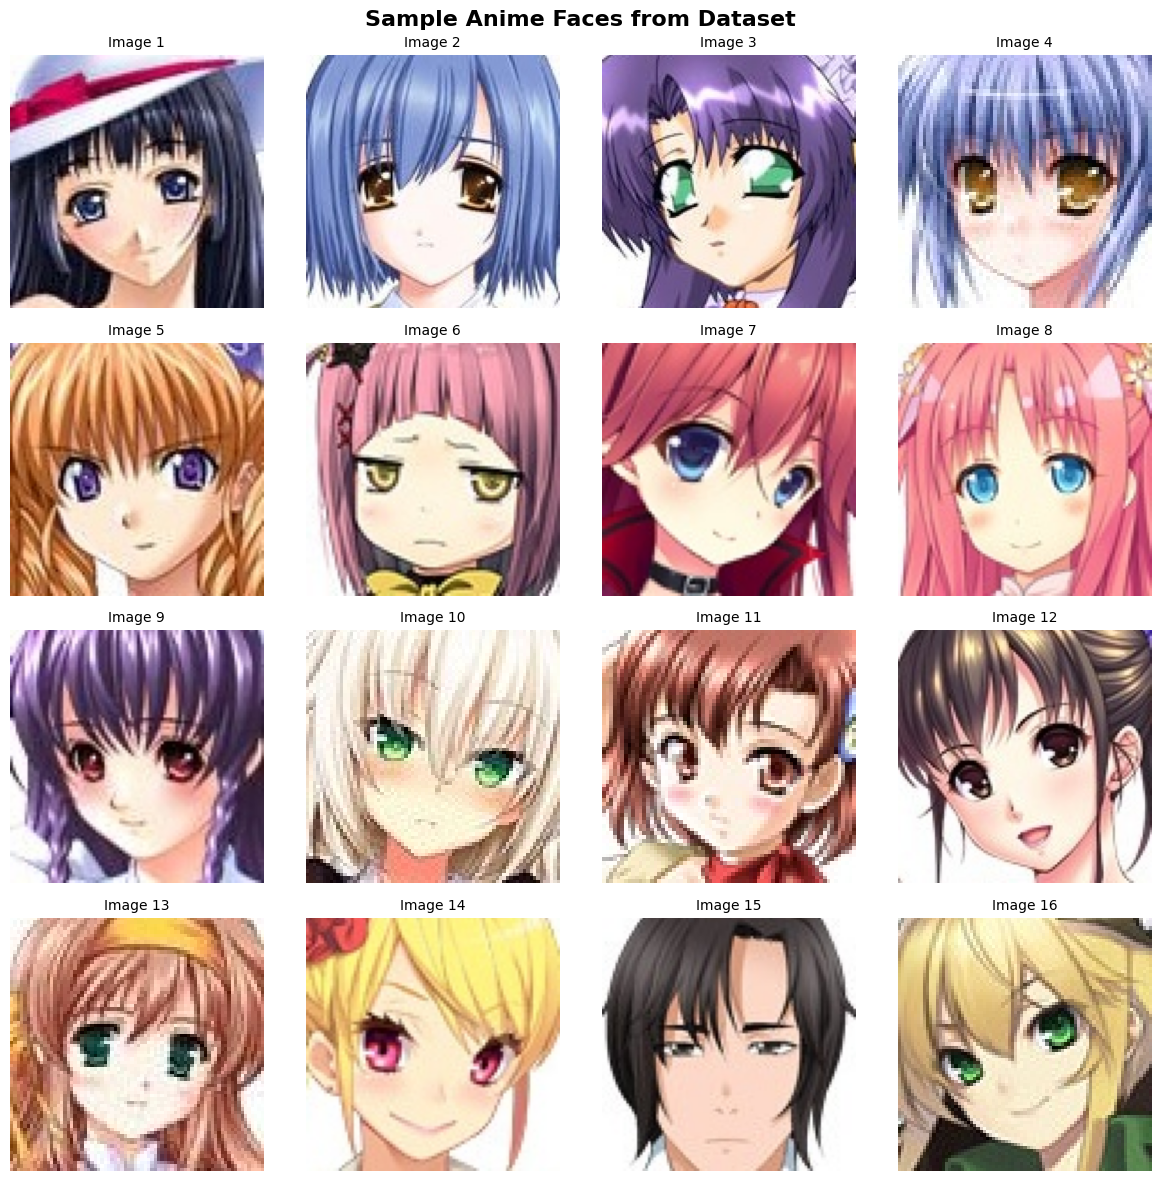

In [7]:
def display_sample_images(image_files, dataset_path, num_samples=16):
    """Display a grid of sample images from the dataset"""
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    fig.suptitle('Sample Anime Faces from Dataset', fontsize=16, fontweight='bold')
    
    sample_files = np.random.choice(image_files, num_samples, replace=False)
    
    for i, ax in enumerate(axes.flat):
        if i < len(sample_files):
            img_path = os.path.join(dataset_path, sample_files[i])
            try:
                img = Image.open(img_path)
                ax.imshow(img)
                ax.set_title(f'Image {i+1}', fontsize=10)
            except Exception as e:
                ax.text(0.5, 0.5, 'Error loading image', ha='center', va='center')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Display sample images
display_sample_images(image_files, DATASET_PATH)

## Image Properties Analysis

Let's analyze the dimensions, color distribution, and other properties of our images to inform our preprocessing pipeline.


In [8]:
def analyze_images(image_files, dataset_path, sample_size=1000):
    """Analyze image properties from a sample of the dataset"""
    sample_files = np.random.choice(image_files, min(sample_size, len(image_files)), replace=False)
    
    widths, heights, channels = [], [], []
    file_sizes = []
    
    print("Analyzing image properties...")
    for filename in tqdm(sample_files[:100]):  # Analyze first 100 for speed
        try:
            img_path = os.path.join(dataset_path, filename)
            img = Image.open(img_path)
            width, height = img.size
            
            widths.append(width)
            heights.append(height)
            channels.append(len(img.getbands()))
            file_sizes.append(os.path.getsize(img_path))
            
        except Exception as e:
            continue
    
    return {
        'widths': widths,
        'heights': heights,
        'channels': channels,
        'file_sizes': file_sizes
    }

Analyzing image properties...


100%|██████████| 100/100 [00:00<00:00, 111.53it/s]


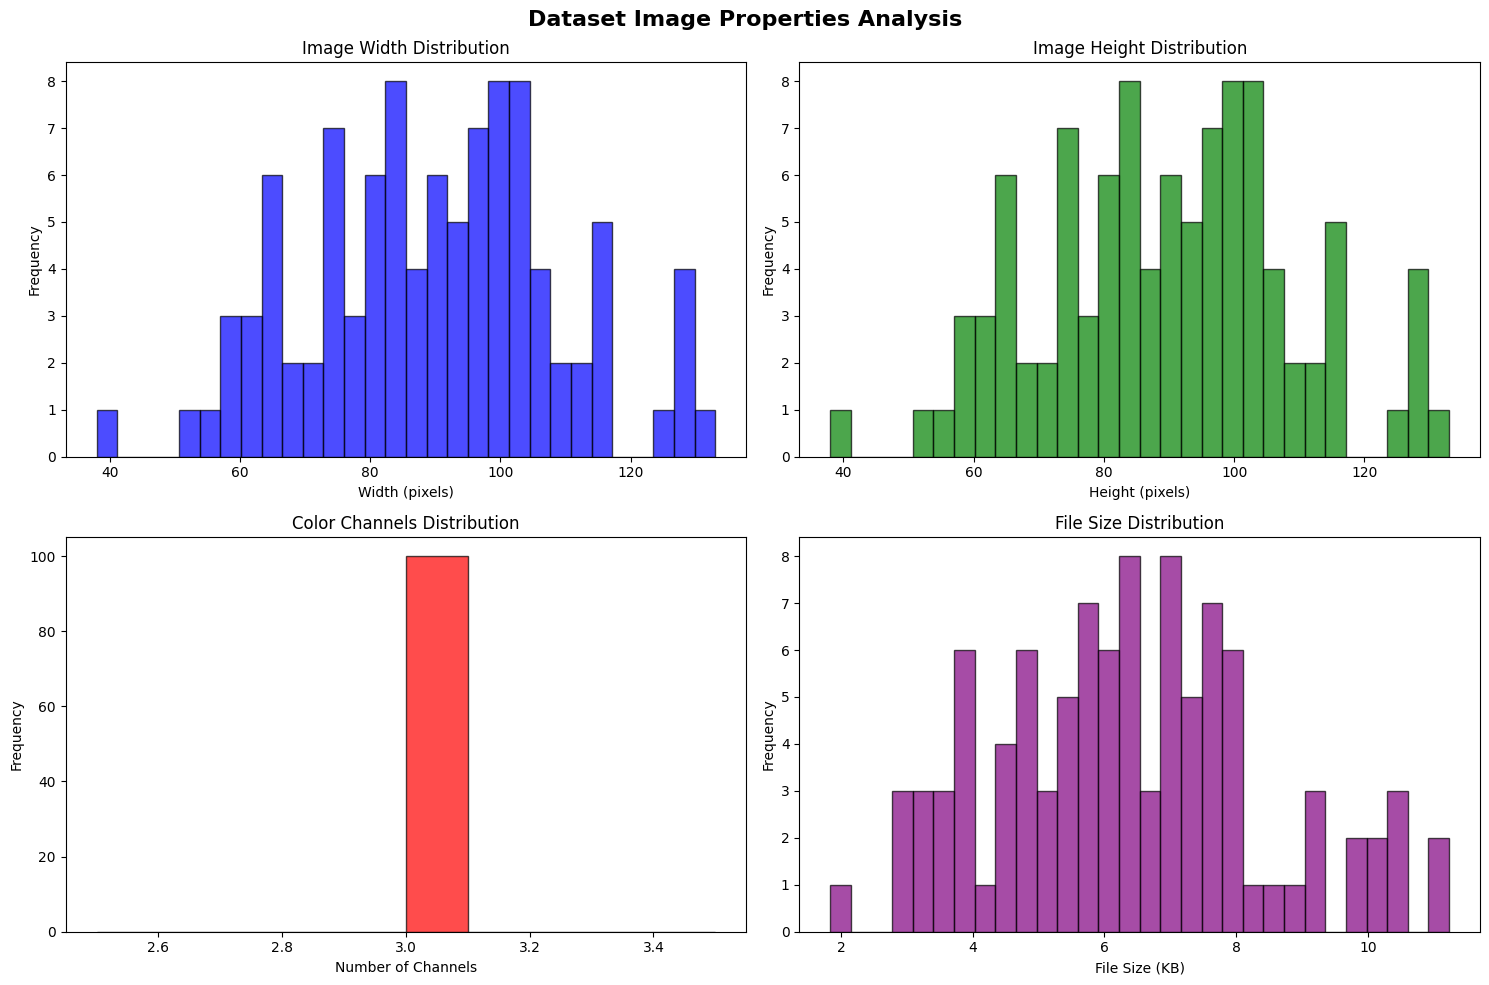

In [9]:
# Analyze images
image_stats = analyze_images(image_files, DATASET_PATH)

# Create visualization of image properties
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Dataset Image Properties Analysis', fontsize=16, fontweight='bold')

# Width distribution
axes[0, 0].hist(image_stats['widths'], bins=30, alpha=0.7, color='blue', edgecolor='black')
axes[0, 0].set_title('Image Width Distribution')
axes[0, 0].set_xlabel('Width (pixels)')
axes[0, 0].set_ylabel('Frequency')

# Height distribution
axes[0, 1].hist(image_stats['heights'], bins=30, alpha=0.7, color='green', edgecolor='black')
axes[0, 1].set_title('Image Height Distribution')
axes[0, 1].set_xlabel('Height (pixels)')
axes[0, 1].set_ylabel('Frequency')

# Channels distribution
axes[1, 0].hist(image_stats['channels'], bins=10, alpha=0.7, color='red', edgecolor='black')
axes[1, 0].set_title('Color Channels Distribution')
axes[1, 0].set_xlabel('Number of Channels')
axes[1, 0].set_ylabel('Frequency')

# File sizes distribution
axes[1, 1].hist([size/1024 for size in image_stats['file_sizes']], bins=30, alpha=0.7, color='purple', edgecolor='black')
axes[1, 1].set_title('File Size Distribution')
axes[1, 1].set_xlabel('File Size (KB)')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [10]:
# Print statistics
print(f"Image Statistics:")
print(f"Average Width: {np.mean(image_stats['widths']):.1f} ± {np.std(image_stats['widths']):.1f}")
print(f"Average Height: {np.mean(image_stats['heights']):.1f} ± {np.std(image_stats['heights']):.1f}")
print(f"Most common channels: {max(set(image_stats['channels']), key=image_stats['channels'].count)}")
print(f"Average file size: {np.mean(image_stats['file_sizes'])/1024:.1f} KB")


Image Statistics:
Average Width: 89.3 ± 19.2
Average Height: 89.3 ± 19.2
Most common channels: 3
Average file size: 6.4 KB


## Data Preprocessing Pipeline

Now we'll create a robust preprocessing pipeline to prepare our images for GAN training:

1. **Resize** images to a consistent size (64x64 pixels)
2. **Normalize** pixel values to [-1, 1] range
3. **Create batches** for efficient training
4. **Apply data augmentation** to increase dataset diversity



In [11]:
img_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),  # Converts to [0, 1] and C, H, W
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalizes to [-1, 1]
])

In [12]:
class AnimeDataset(Dataset):
    def __init__(self, data_path, transform=None):
        self.data_path = data_path
        self.transform = transform
        self.image_files = [f for f in os.listdir(data_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.data_path, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
            
        return image

In [13]:
# image_paths = [os.path.join(DATASET_PATH, f) for f in image_files]

# Create the dataset instance
anime_dataset = AnimeDataset(DATASET_PATH, transform=img_transforms)
print(f"Dataset created successfully!")

train_dataloader = DataLoader(anime_dataset, 
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=4,) # num_workers for parallel loading

dataset_size = len(anime_dataset)
print(f"Total training samples: {dataset_size}")
print(f"Batches per epoch: {len(train_dataloader)}")
print(f"Image shape: {(3, IMG_SIZE, IMG_SIZE)}")
print(f"Batch size: {BATCH_SIZE}")

Dataset created successfully!
Total training samples: 63565
Batches per epoch: 994
Image shape: (3, 64, 64)
Batch size: 64


## Visualizing Preprocessed Data

Let's verify our preprocessing pipeline by visualizing some processed images to ensure they look correct.

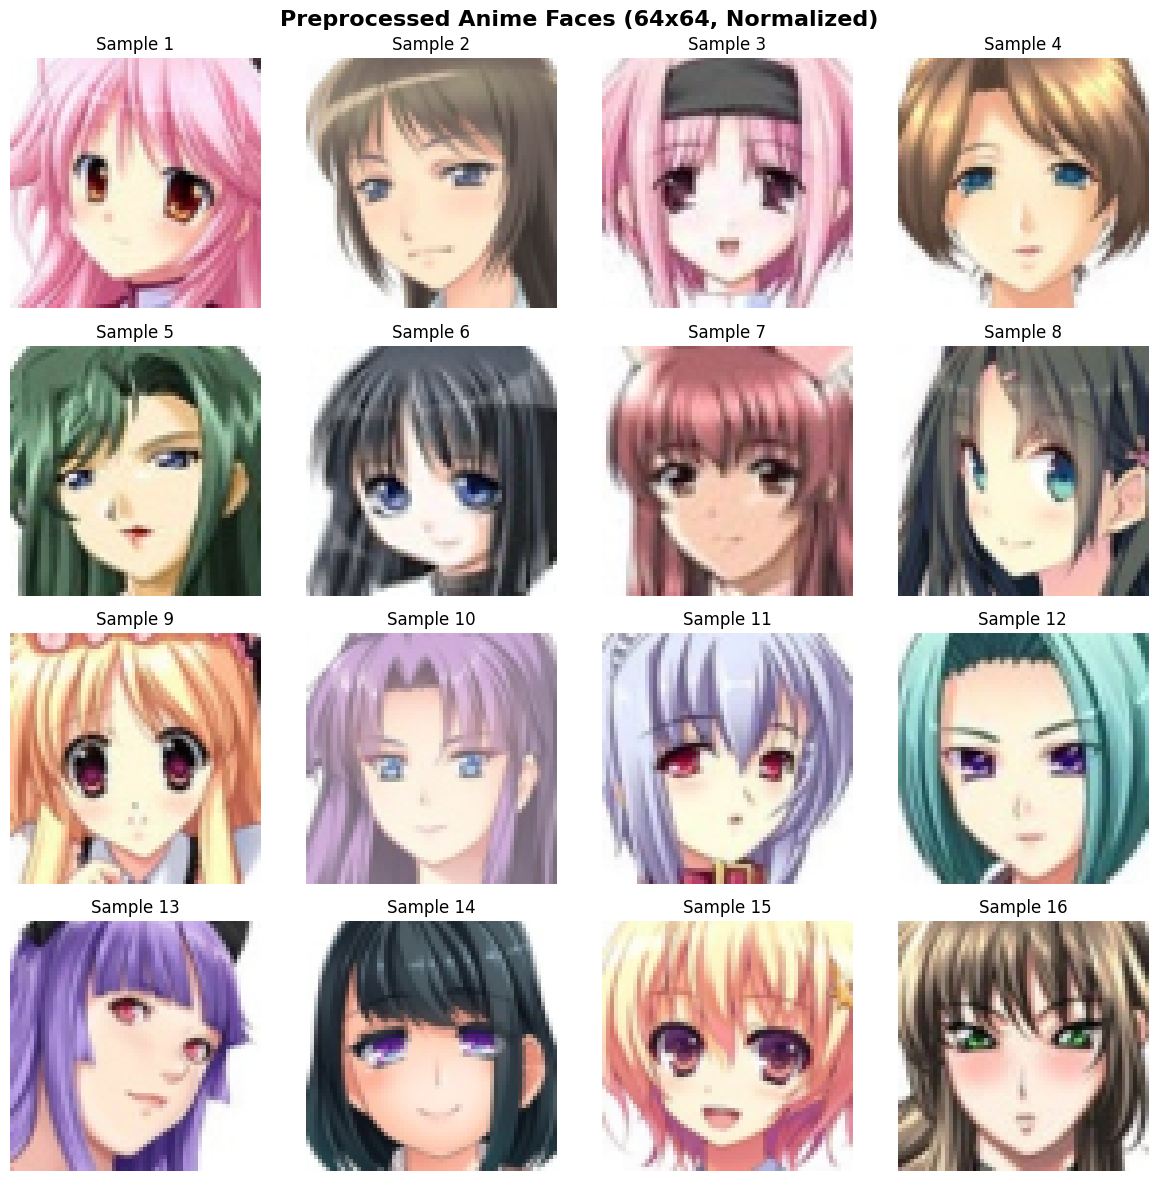

In [14]:
def show_preprocessed_batch(dataloader, num_images=16):
    """Display a batch of preprocessed images"""
    # Get one batch from the dataloader
    batch = next(iter(dataloader))
    batch = batch.to(device if device.type != 'mps' else 'cpu')
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    fig.suptitle('Preprocessed Anime Faces (64x64, Normalized)', fontsize=16, fontweight='bold')

    for i, ax in enumerate(axes.flat):
        if i < num_images and i < batch.size(0):
            # Denormalize for display
            img = batch[i] * 0.5 + 0.5  # From [-1, 1] to [0, 1]
            img = torch.clamp(img, 0.0, 1.0)
            ax.imshow(img.cpu().permute(1, 2, 0).numpy())
            ax.set_title(f'Sample {i+1}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

show_preprocessed_batch(train_dataloader)

## GAN Architecture: Generator Network

The Generator network transforms random noise into realistic anime faces. Our architecture uses:

- **Transpose Convolutions** for upsampling
- **Batch Normalization** for stable training
- **LeakyReLU** activations for better gradient flow
- **Progressive upsampling** from 4x4 to 64x64

The generator starts with a 100-dimensional noise vector and progressively upsamples to create 64x64x3 images.


In [15]:
class Generator(nn.Module):
    def __init__(self, latent_dim=100, img_channels=3, feature_maps=64):
        super(Generator, self).__init__()
        
        self.main = nn.Sequential(
            # Input: latent_dim x 1 x 1
            nn.ConvTranspose2d(latent_dim, feature_maps * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(feature_maps * 8),
            nn.ReLU(True),
            # State: (feature_maps*8) x 4 x 4
            
            nn.ConvTranspose2d(feature_maps * 8, feature_maps * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps * 4),
            nn.ReLU(True),
            # State: (feature_maps*4) x 8 x 8
            
            nn.ConvTranspose2d(feature_maps * 4, feature_maps * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps * 2),
            nn.ReLU(True),
            # State: (feature_maps*2) x 16 x 16
            
            nn.ConvTranspose2d(feature_maps * 2, feature_maps, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps),
            nn.ReLU(True),
            # State: feature_maps x 32 x 32
            
            nn.ConvTranspose2d(feature_maps, img_channels, 4, 2, 1, bias=False),
            nn.Tanh()
            # Output: img_channels x 64 x 64
        )
    
    def forward(self, x):
        return self.main(x)

In [16]:
generator = Generator(NOISE_DIM).to(device)

# Display model architecture
print("Generator Architecture:")
print(generator)

Generator Architecture:
Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)

## GAN Architecture: Discriminator Network

The Discriminator acts as a binary classifier, distinguishing real anime faces from generated ones. Key features:

- **Convolutional layers** for feature extraction
- **Leaky ReLU** activations to prevent dying neurons
- **Dropout** for regularization
- **Batch normalization** is used in most layers to help stabilize training
- **Binary output** (real vs fake probability)


In [17]:
class Discriminator(nn.Module):
    def __init__(self, img_channels=3, feature_maps=64):
        super(Discriminator, self).__init__()
        
        self.main = nn.Sequential(
            # Input: img_channels x 64 x 64
            nn.Conv2d(img_channels, feature_maps, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # State: feature_maps x 32 x 32
            
            nn.Conv2d(feature_maps, feature_maps * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # State: (feature_maps*2) x 16 x 16
            
            nn.Conv2d(feature_maps * 2, feature_maps * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # State: (feature_maps*4) x 8 x 8
            
            nn.Conv2d(feature_maps * 4, feature_maps * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_maps * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # State: (feature_maps*8) x 4 x 4
            
            nn.Conv2d(feature_maps * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
            # Output: 1 x 1 x 1
        )
    
    def forward(self, x):
        return self.main(x).view(-1, 1).squeeze(1)

In [18]:
discriminator = Discriminator().to(device)

# Display model architecture
print("Discriminator Architecture:")
print(discriminator)

Discriminator Architecture:
Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


## Loss Functions and Optimizers

We'll use Binary Cross-Entropy loss for both networks:

- **Generator Loss**: Wants discriminator to classify fake images as real
- **Discriminator Loss**: Wants to correctly classify real vs fake images

We use separate Adam optimizers with different learning rates for stability.


In [19]:
# Weight initialization function
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Apply weight initialization
generator.apply(weights_init)
discriminator.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [20]:
# Loss function
criterion = nn.BCELoss()

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))

print("Models initialized successfully!")
print(f"Generator parameters: {sum(p.numel() for p in generator.parameters()):,}")
print(f"Discriminator parameters: {sum(p.numel() for p in discriminator.parameters()):,}")

Models initialized successfully!
Generator parameters: 3,576,704
Discriminator parameters: 2,765,568


## Training Setup and Checkpoints

We'll set up checkpointing to save our model progress and enable resuming training if needed.


In [21]:
# Checkpoint setup
checkpoint_dir = './training_checkpoints_pytorch'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

In [22]:
# Create fixed noise for consistent visualization
fixed_noise = torch.randn(num_examples_to_generate, NOISE_DIM, device=device)

print("Training setup complete!")
print(f"Checkpoint directory: {checkpoint_dir}")

Training setup complete!
Checkpoint directory: ./training_checkpoints_pytorch


## Training Functions

Here we define the core training functions that will be executed for each batch:

1. **train_step**: Performs one training iteration
2. **generate_and_save_images**: Creates and displays generated samples
3. **Training loop**: Orchestrates the entire training process


In [23]:
def generate_and_save_images(model_G, epoch, test_input_noise): 
    """Generate and display images during training"""
    model_G.eval()
    with torch.no_grad(): 
        predictions = model_G(test_input_noise).cpu() 
    model_G.train() 
    
    fig = plt.figure(figsize=(8, 8))
    fig.suptitle(f'Generated Images - Epoch {epoch}', fontsize=16, fontweight='bold')
    
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        img = predictions[i] * 0.5 + 0.5 # Denormalize from [-1, 1] to [0, 1]
        img = torch.clamp(img, 0.0, 1.0)
        
        plt.imshow(img.permute(1, 2, 0).numpy())
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [24]:
def generate_samples(generator, latent_dim, device, num_samples=16):
    generator.eval()
    with torch.no_grad():
        noise = torch.randn(num_samples, latent_dim, 1, 1, device=device)
        fake_images = generator(noise)
        
        # Denormalize images
        fake_images = (fake_images + 1) / 2
        fake_images = torch.clamp(fake_images, 0, 1)
        
        # Create grid
        fig, axes = plt.subplots(4, 4, figsize=(10, 10))
        fig.suptitle('Generated Anime Faces', fontsize=16)
        
        for i in range(num_samples):
            row, col = i // 4, i % 4
            img = fake_images[i].cpu().permute(1, 2, 0)
            axes[row, col].imshow(img)
            axes[row, col].axis('off')
        
        plt.tight_layout()
        plt.show()
    
    generator.train()

## Main Training Loop

Now we'll start the main training process! The GAN will train for the specified number of epochs, 
and we'll visualize the progress by generating sample images at regular intervals.

**What to expect:**
- Initial images will look like noise
- Gradually, face-like structures will emerge
- After several epochs, we should see recognizable anime faces
- Training time depends on the hardware (GPU recommended)

In [25]:
def train_gan(dataloader, generator, discriminator, optimizer_G, optimizer_D, criterion, noise_dim, fixed_noise, device):
    d_losses = []
    g_losses = []
    d_losses_iter = []
    g_losses_iter = []
    
    print("Starting Training...")
    print(f"Training for {EPOCHS} epochs with {len(dataloader)} batches per epoch")
    
    for epoch in range(EPOCHS):
        epoch_g_loss = 0
        epoch_d_loss = 0
        num_batches = 0
        
        # Progress bar for current epoch
        pbar = tqdm(dataloader, desc=f'Epoch {epoch+1}/{EPOCHS}')
        
        for i, real_images in enumerate(pbar):
            current_batch_size = real_images.size(0)
            real_images = real_images.to(device)
            
            # Labels
            real_labels = torch.ones(current_batch_size, device=device)
            fake_labels = torch.zeros(current_batch_size, device=device)
            
            # ---------------------
            # Train Discriminator
            # ---------------------
            
            # Train with real images
            discriminator.zero_grad()
            output_real = discriminator(real_images)
            loss_real = criterion(output_real, real_labels)
            
            # Train with fake images
            noise = torch.randn(current_batch_size, noise_dim, 1, 1, device=device)
            fake_images = generator(noise)
            output_fake = discriminator(fake_images.detach())
            loss_fake = criterion(output_fake, fake_labels)
            
            # Total discriminator loss
            loss_D = loss_real + loss_fake
            loss_D.backward()
            optimizer_D.step()      
            
            # -----------------
            # Train Generator
            # -----------------
            
            generator.zero_grad()
            output_fake = discriminator(fake_images)
            loss_G = criterion(output_fake, real_labels)
            loss_G.backward()
            optimizer_G.step()
            
            # Accumulate batch losses
            epoch_d_loss += loss_D.item()
            epoch_g_loss += loss_G.item()
            num_batches += 1
            
            # Update progress bar
            pbar.set_postfix({
                'D_loss': f'{loss_D.item():.4f}',
                'G_loss': f'{loss_G.item():.4f}'
            })

        # Calculate average loss for the epoch
        avg_d_loss = epoch_d_loss / num_batches
        avg_g_loss = epoch_g_loss / num_batches
        
        # Store the average epoch loss
        d_losses.append(avg_d_loss)
        g_losses.append(avg_g_loss)
        
        # # Print epoch summary
        avg_g_loss_iter = epoch_g_loss / len(dataloader)
        avg_d_loss_iter = epoch_d_loss / len(dataloader)
        d_losses_iter.append(avg_d_loss_iter)
        g_losses_iter.append(avg_g_loss_iter)
        
        print(f'Epoch [{epoch+1}/{EPOCHS}] - G_loss: {avg_g_loss:.4f}, D_loss: {avg_d_loss:.4f}')
        
        # Generate and display samples every SAMPLE_INTERVAL epochs
        if (epoch + 1) % SAMPLE_INTERVAL == 0:
            print(f"\n--- Generated Samples at Epoch {epoch+1} ---")
            generate_samples(generator, noise_dim, device)
            
            # Plot training losses
            if len(g_losses) > 10:
                plot_losses(g_losses_iter, d_losses_iter)
            
            print("-" * 50)
    
    print("Training completed!")
    return g_losses, d_losses

In [26]:
def plot_losses(g_losses, d_losses):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(g_losses, label='Generator Loss', color='blue')
    plt.plot(d_losses, label='Discriminator Loss', color='red')
    plt.title('Training Losses')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(g_losses[-100:], label='Generator Loss (Last 100)', color='blue')
    plt.plot(d_losses[-100:], label='Discriminator Loss (Last 100)', color='red')
    plt.title('Recent Training Losses')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

Starting Anime Face GAN Training (PyTorch)!
Training with 63565 images for 50 epochs using PyTorch.
Starting Training...
Training for 50 epochs with 994 batches per epoch


Epoch 1/50: 100%|██████████| 994/994 [02:20<00:00,  7.08it/s, D_loss=0.4378, G_loss=5.7059]


Epoch [1/50] - G_loss: 7.2477, D_loss: 0.6542


Epoch 2/50: 100%|██████████| 994/994 [01:01<00:00, 16.10it/s, D_loss=0.2262, G_loss=6.6392]


Epoch [2/50] - G_loss: 6.2154, D_loss: 0.5082


Epoch 3/50: 100%|██████████| 994/994 [01:01<00:00, 16.08it/s, D_loss=0.1540, G_loss=5.0104]


Epoch [3/50] - G_loss: 6.2943, D_loss: 0.4127


Epoch 4/50: 100%|██████████| 994/994 [01:01<00:00, 16.09it/s, D_loss=0.0726, G_loss=6.1265]


Epoch [4/50] - G_loss: 5.6647, D_loss: 0.4565


Epoch 5/50: 100%|██████████| 994/994 [01:01<00:00, 16.09it/s, D_loss=0.4225, G_loss=5.5937]


Epoch [5/50] - G_loss: 5.1135, D_loss: 0.4685

--- Generated Samples at Epoch 5 ---


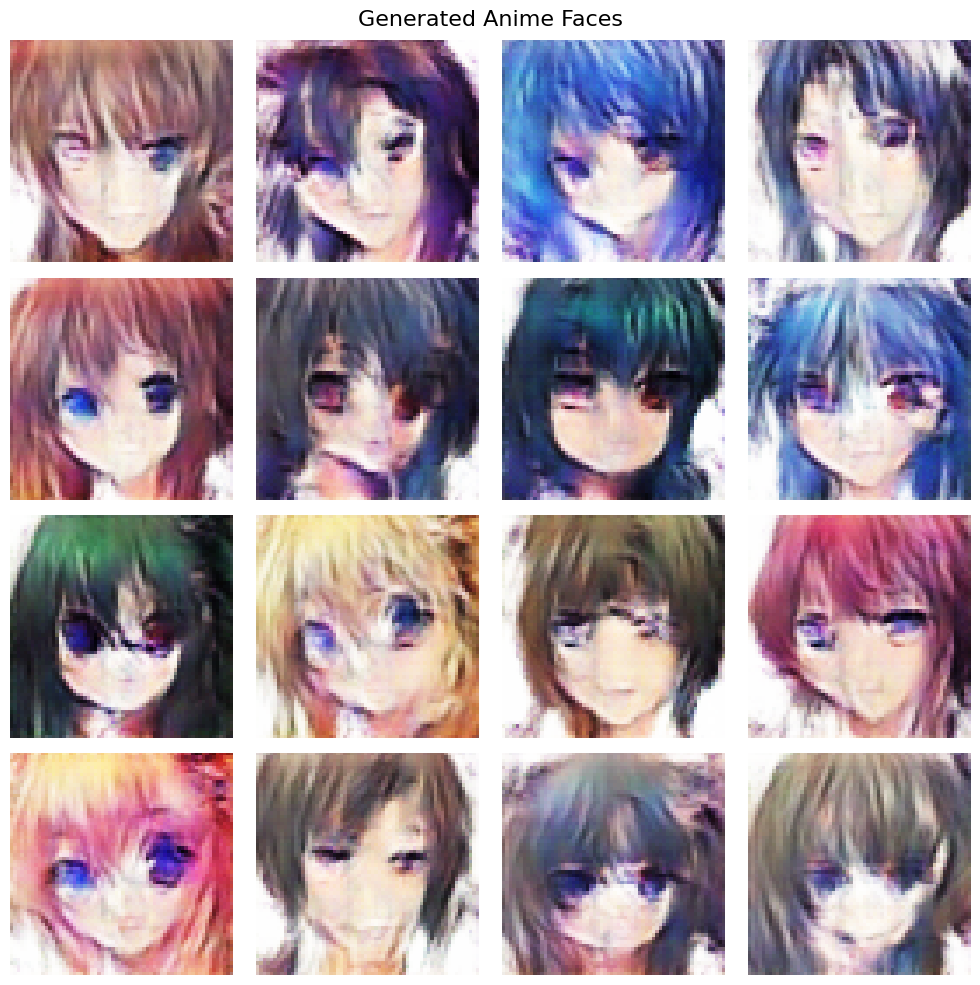

--------------------------------------------------


Epoch 6/50: 100%|██████████| 994/994 [01:01<00:00, 16.09it/s, D_loss=1.1036, G_loss=12.5839]


Epoch [6/50] - G_loss: 5.0075, D_loss: 0.4490


Epoch 7/50: 100%|██████████| 994/994 [01:01<00:00, 16.09it/s, D_loss=0.2784, G_loss=2.7621]


Epoch [7/50] - G_loss: 4.7526, D_loss: 0.4445


Epoch 8/50: 100%|██████████| 994/994 [01:01<00:00, 16.09it/s, D_loss=1.4255, G_loss=9.6874]


Epoch [8/50] - G_loss: 4.3082, D_loss: 0.4614


Epoch 9/50: 100%|██████████| 994/994 [01:01<00:00, 16.09it/s, D_loss=0.7061, G_loss=10.9392]


Epoch [9/50] - G_loss: 4.1989, D_loss: 0.4490


Epoch 10/50: 100%|██████████| 994/994 [01:01<00:00, 16.09it/s, D_loss=0.2181, G_loss=3.4241]


Epoch [10/50] - G_loss: 4.2394, D_loss: 0.4408

--- Generated Samples at Epoch 10 ---


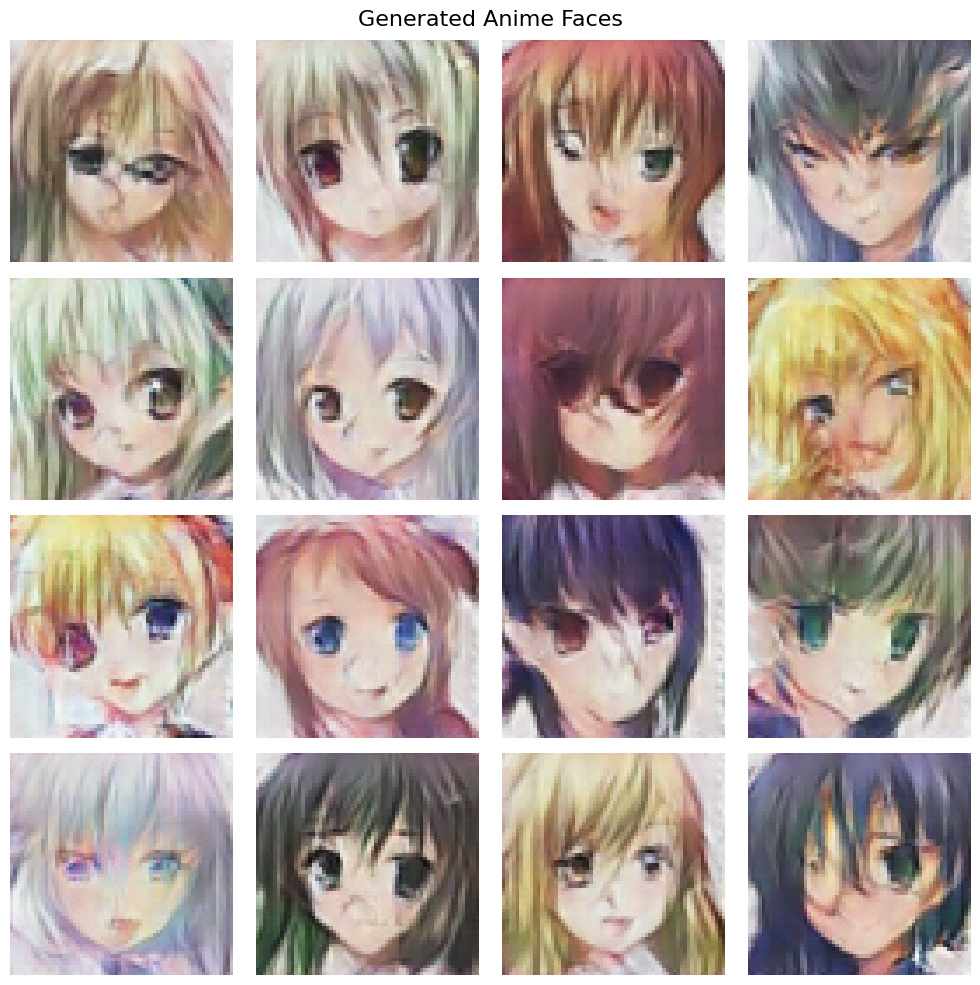

--------------------------------------------------


Epoch 11/50: 100%|██████████| 994/994 [01:01<00:00, 16.08it/s, D_loss=0.7559, G_loss=2.1561]


Epoch [11/50] - G_loss: 4.2609, D_loss: 0.4133


Epoch 12/50: 100%|██████████| 994/994 [01:01<00:00, 16.10it/s, D_loss=0.0818, G_loss=4.4717]


Epoch [12/50] - G_loss: 4.2071, D_loss: 0.3888


Epoch 13/50: 100%|██████████| 994/994 [01:01<00:00, 16.19it/s, D_loss=0.1797, G_loss=3.7509]


Epoch [13/50] - G_loss: 4.2863, D_loss: 0.4072


Epoch 14/50: 100%|██████████| 994/994 [01:01<00:00, 16.24it/s, D_loss=0.2343, G_loss=1.3105]


Epoch [14/50] - G_loss: 4.4593, D_loss: 0.3365


Epoch 15/50: 100%|██████████| 994/994 [01:01<00:00, 16.26it/s, D_loss=0.1428, G_loss=3.2085]


Epoch [15/50] - G_loss: 4.3341, D_loss: 0.4028

--- Generated Samples at Epoch 15 ---


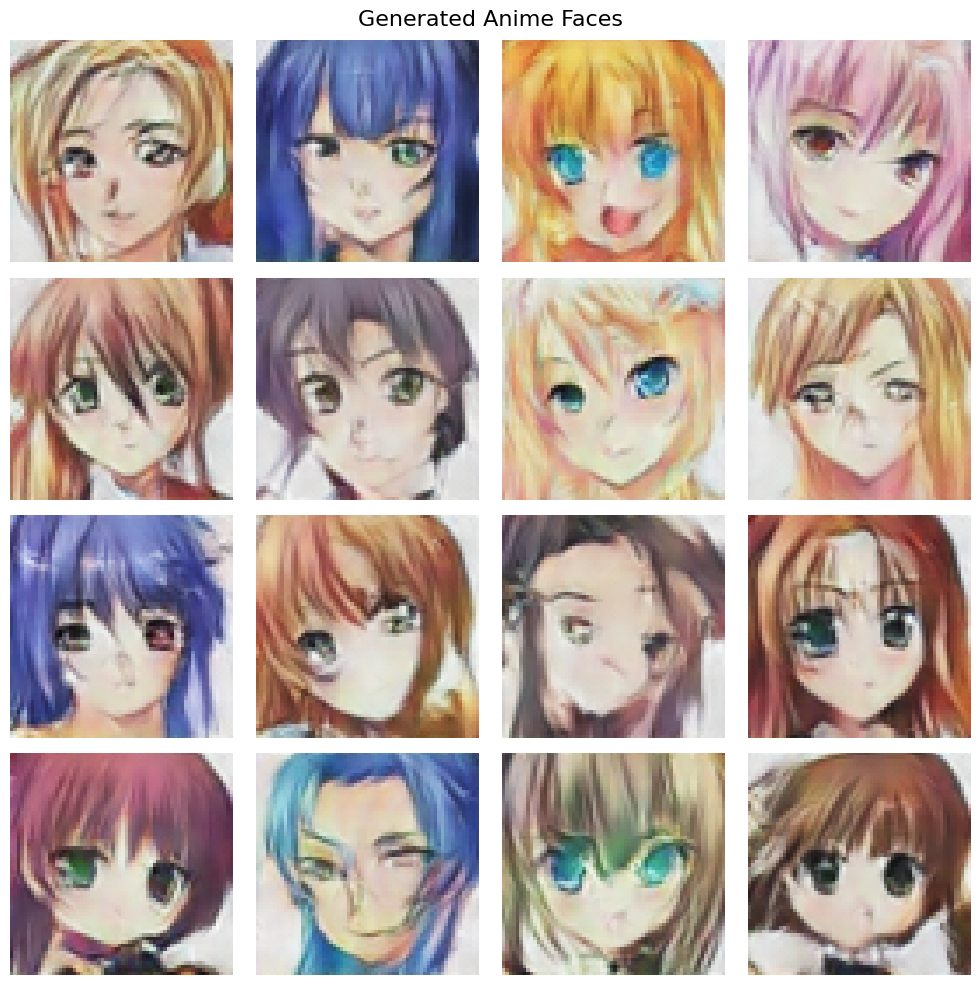

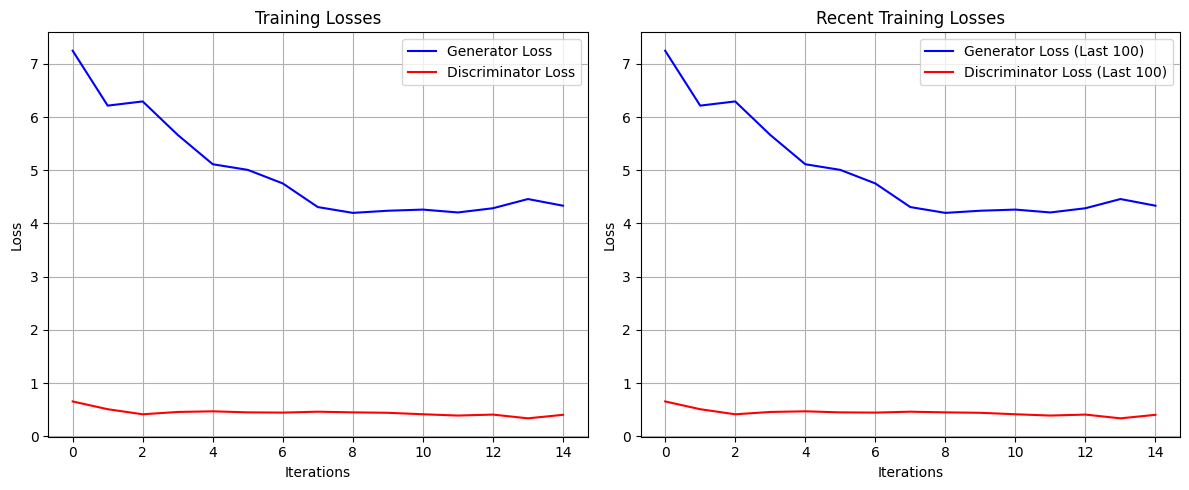

--------------------------------------------------


Epoch 16/50: 100%|██████████| 994/994 [01:01<00:00, 16.25it/s, D_loss=1.2804, G_loss=2.1183]


Epoch [16/50] - G_loss: 4.4769, D_loss: 0.3272


Epoch 17/50: 100%|██████████| 994/994 [01:00<00:00, 16.36it/s, D_loss=0.1709, G_loss=7.0889]


Epoch [17/50] - G_loss: 4.5380, D_loss: 0.3549


Epoch 18/50: 100%|██████████| 994/994 [01:01<00:00, 16.26it/s, D_loss=0.0673, G_loss=5.5193]


Epoch [18/50] - G_loss: 4.4839, D_loss: 0.3708


Epoch 19/50: 100%|██████████| 994/994 [01:01<00:00, 16.28it/s, D_loss=0.1104, G_loss=4.5336]


Epoch [19/50] - G_loss: 4.5147, D_loss: 0.3435


Epoch 20/50: 100%|██████████| 994/994 [01:00<00:00, 16.36it/s, D_loss=0.0364, G_loss=4.9834]


Epoch [20/50] - G_loss: 4.6358, D_loss: 0.3199

--- Generated Samples at Epoch 20 ---


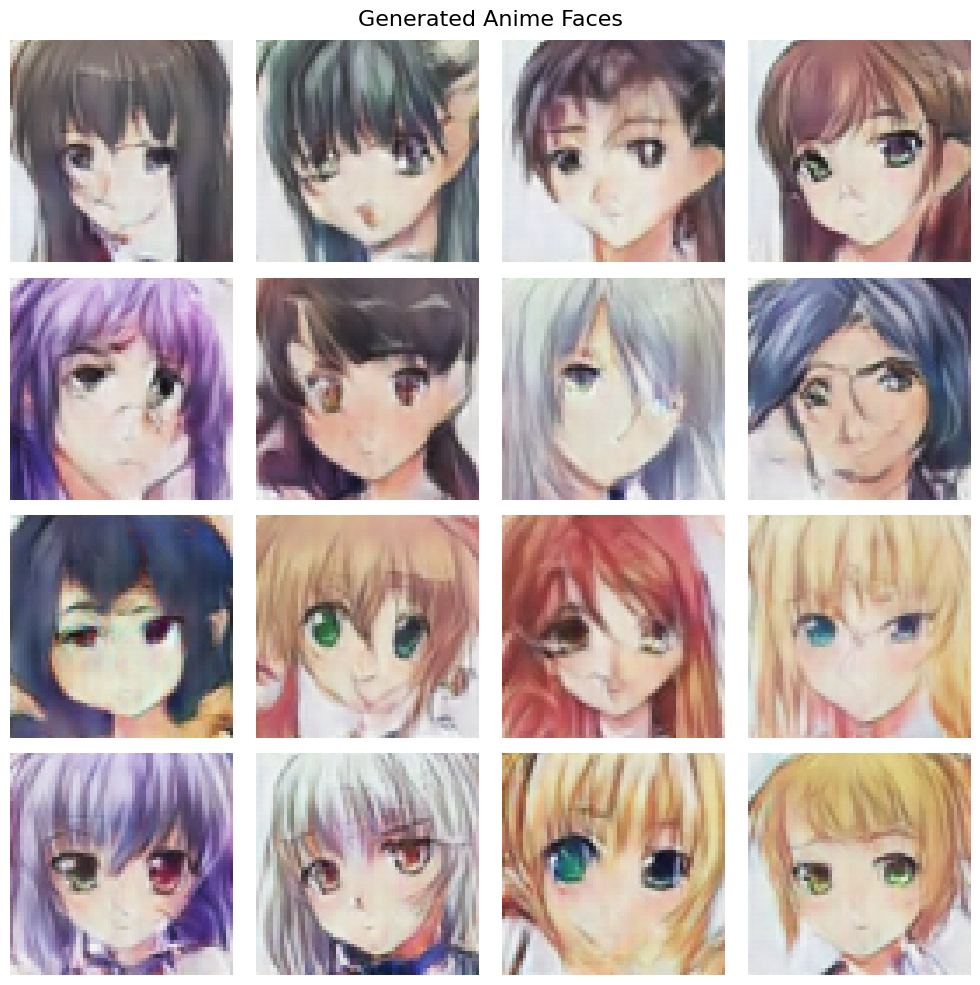

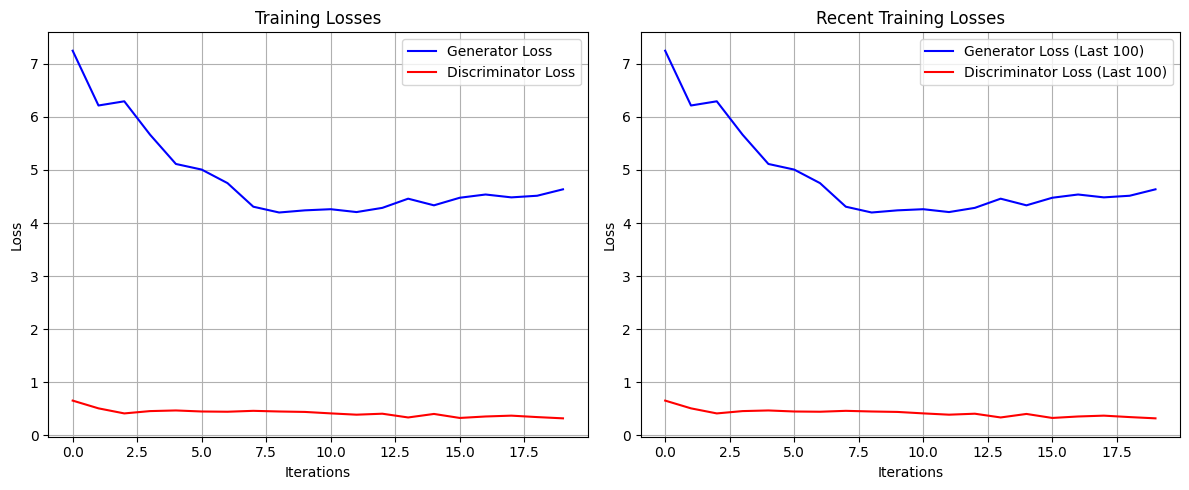

--------------------------------------------------


Epoch 21/50: 100%|██████████| 994/994 [01:00<00:00, 16.36it/s, D_loss=0.0700, G_loss=6.2218]


Epoch [21/50] - G_loss: 4.5443, D_loss: 0.3797


Epoch 22/50: 100%|██████████| 994/994 [01:00<00:00, 16.35it/s, D_loss=2.1113, G_loss=11.9579]


Epoch [22/50] - G_loss: 4.7887, D_loss: 0.2597


Epoch 23/50: 100%|██████████| 994/994 [01:00<00:00, 16.36it/s, D_loss=0.2175, G_loss=0.7709]


Epoch [23/50] - G_loss: 4.8634, D_loss: 0.2634


Epoch 24/50: 100%|██████████| 994/994 [01:00<00:00, 16.36it/s, D_loss=0.2761, G_loss=2.1046]


Epoch [24/50] - G_loss: 4.5546, D_loss: 0.3910


Epoch 25/50: 100%|██████████| 994/994 [01:00<00:00, 16.30it/s, D_loss=0.1579, G_loss=9.0176]


Epoch [25/50] - G_loss: 4.7159, D_loss: 0.3564

--- Generated Samples at Epoch 25 ---


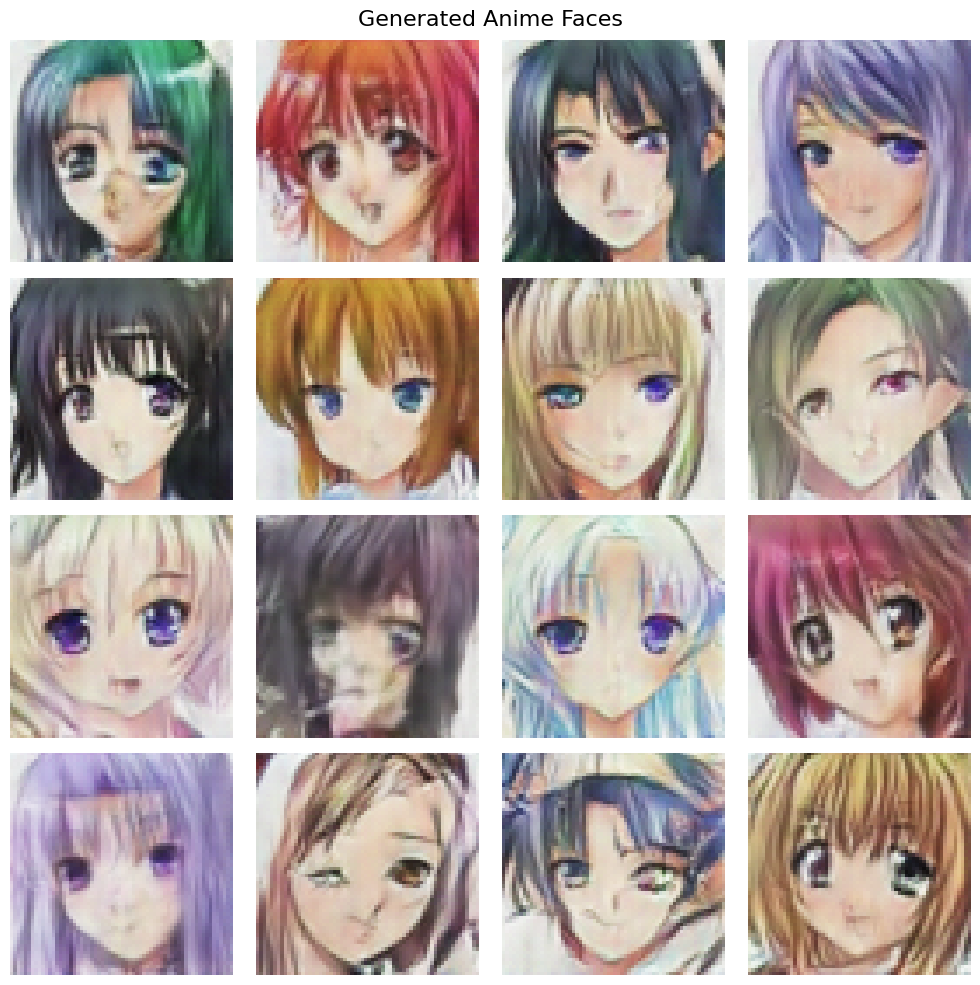

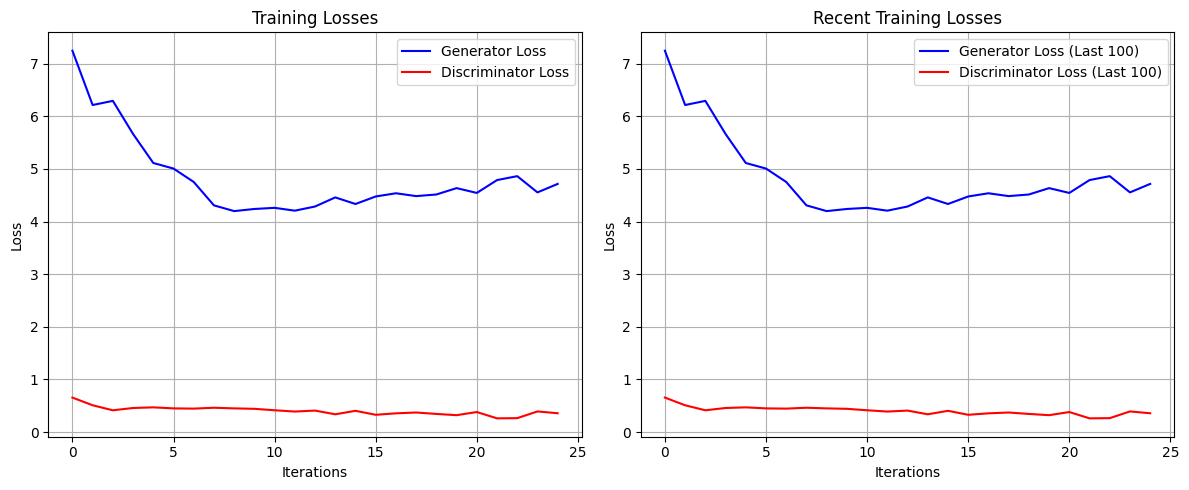

--------------------------------------------------


Epoch 26/50: 100%|██████████| 994/994 [01:00<00:00, 16.32it/s, D_loss=0.4743, G_loss=6.2824]


Epoch [26/50] - G_loss: 4.7322, D_loss: 0.2949


Epoch 27/50: 100%|██████████| 994/994 [01:00<00:00, 16.35it/s, D_loss=0.0136, G_loss=6.7892]


Epoch [27/50] - G_loss: 4.9278, D_loss: 0.2381


Epoch 28/50: 100%|██████████| 994/994 [01:00<00:00, 16.38it/s, D_loss=0.4936, G_loss=8.5509]


Epoch [28/50] - G_loss: 4.6714, D_loss: 0.3496


Epoch 29/50: 100%|██████████| 994/994 [01:00<00:00, 16.38it/s, D_loss=0.2534, G_loss=4.9359]


Epoch [29/50] - G_loss: 4.6104, D_loss: 0.3632


Epoch 30/50: 100%|██████████| 994/994 [01:00<00:00, 16.37it/s, D_loss=0.4915, G_loss=8.2171]


Epoch [30/50] - G_loss: 4.9439, D_loss: 0.2437

--- Generated Samples at Epoch 30 ---


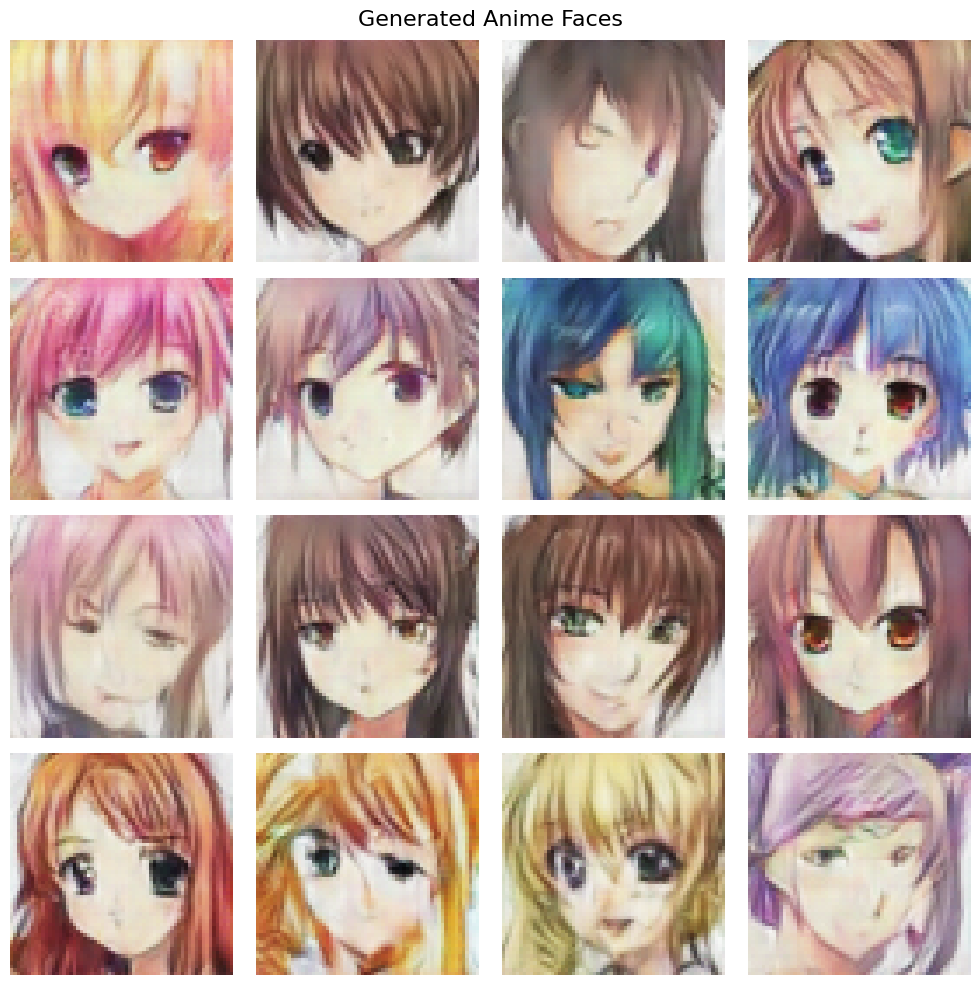

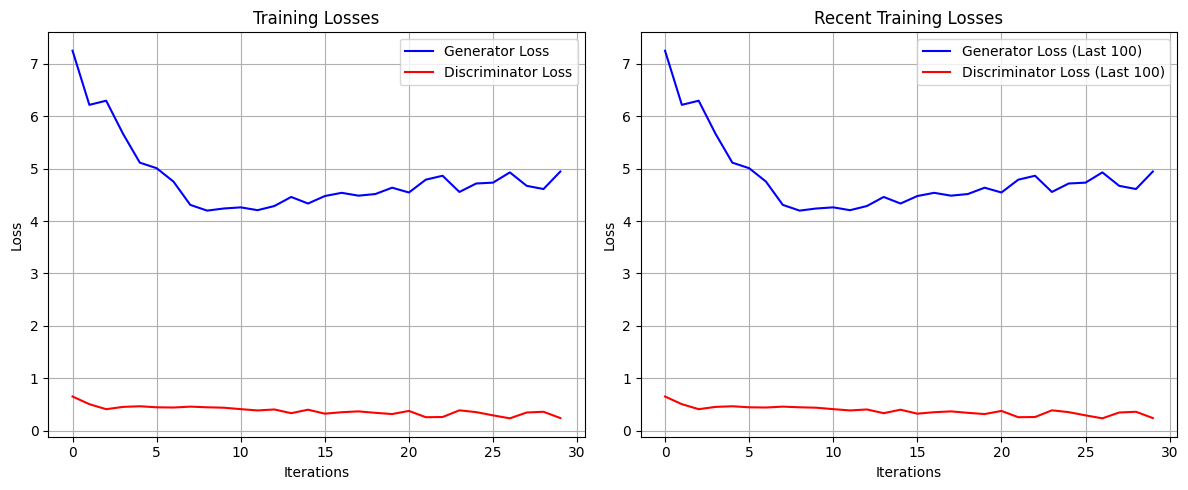

--------------------------------------------------


Epoch 31/50: 100%|██████████| 994/994 [01:00<00:00, 16.37it/s, D_loss=0.0679, G_loss=6.4807]


Epoch [31/50] - G_loss: 4.7676, D_loss: 0.3174


Epoch 32/50: 100%|██████████| 994/994 [01:00<00:00, 16.38it/s, D_loss=0.2863, G_loss=3.3498]


Epoch [32/50] - G_loss: 5.4854, D_loss: 0.1692


Epoch 33/50: 100%|██████████| 994/994 [01:00<00:00, 16.38it/s, D_loss=0.1972, G_loss=3.4154]


Epoch [33/50] - G_loss: 4.4463, D_loss: 0.3988


Epoch 34/50: 100%|██████████| 994/994 [01:00<00:00, 16.36it/s, D_loss=0.2262, G_loss=6.9877]


Epoch [34/50] - G_loss: 4.9831, D_loss: 0.2747


Epoch 35/50: 100%|██████████| 994/994 [01:00<00:00, 16.37it/s, D_loss=0.0045, G_loss=9.1123]


Epoch [35/50] - G_loss: 5.2830, D_loss: 0.1520

--- Generated Samples at Epoch 35 ---


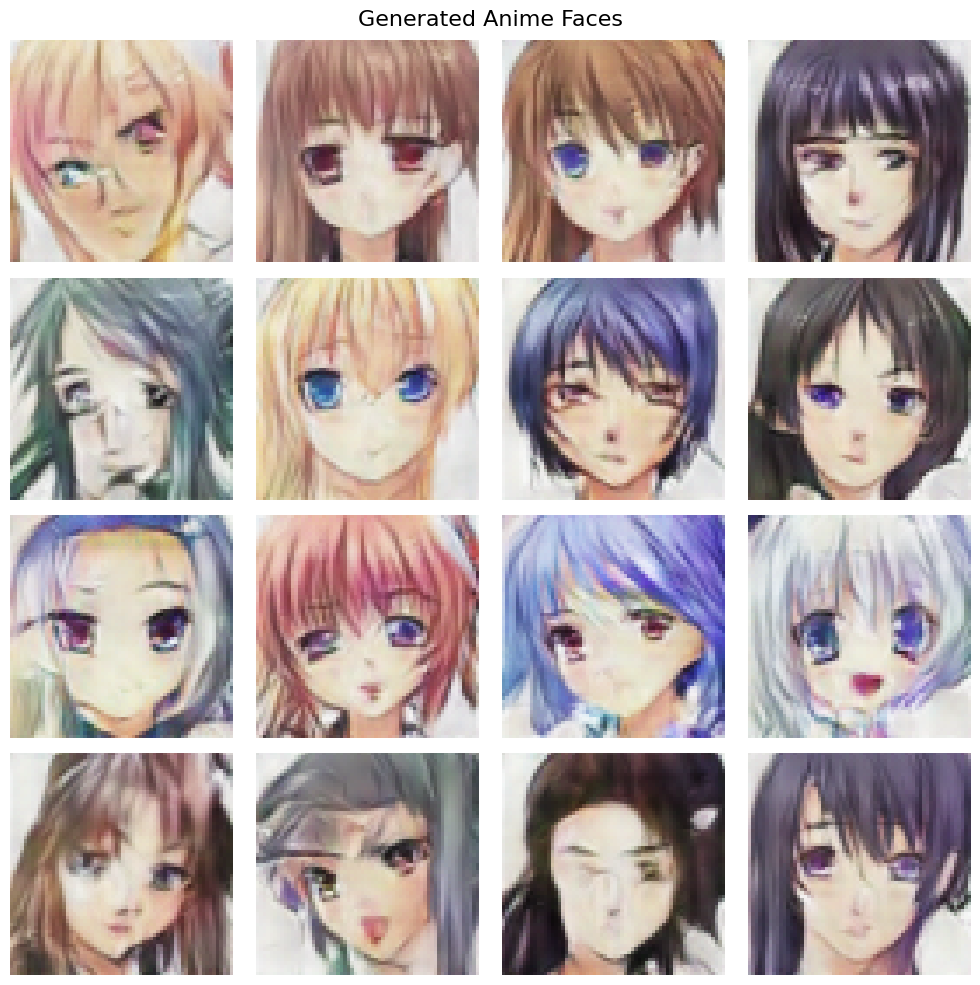

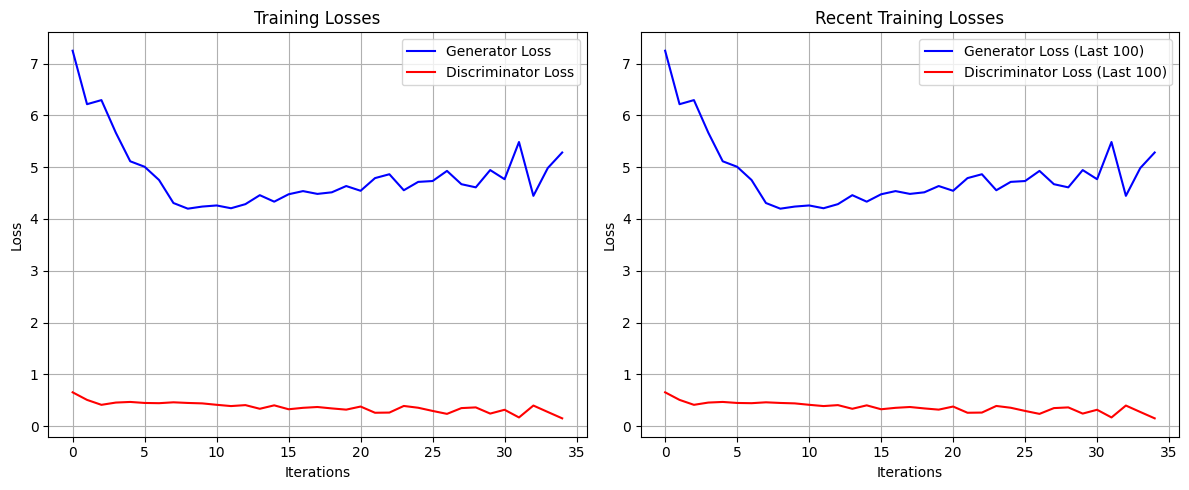

--------------------------------------------------


Epoch 36/50: 100%|██████████| 994/994 [01:00<00:00, 16.37it/s, D_loss=0.0620, G_loss=4.5741]


Epoch [36/50] - G_loss: 4.9749, D_loss: 0.3291


Epoch 37/50: 100%|██████████| 994/994 [01:00<00:00, 16.36it/s, D_loss=0.7072, G_loss=0.3760]


Epoch [37/50] - G_loss: 4.9972, D_loss: 0.2905


Epoch 38/50: 100%|██████████| 994/994 [01:00<00:00, 16.35it/s, D_loss=0.0225, G_loss=5.8324]


Epoch [38/50] - G_loss: 5.1753, D_loss: 0.2264


Epoch 39/50: 100%|██████████| 994/994 [01:00<00:00, 16.37it/s, D_loss=0.0591, G_loss=5.6555]


Epoch [39/50] - G_loss: 5.0390, D_loss: 0.3194


Epoch 40/50: 100%|██████████| 994/994 [01:00<00:00, 16.37it/s, D_loss=0.0273, G_loss=6.1346]


Epoch [40/50] - G_loss: 5.0450, D_loss: 0.2551

--- Generated Samples at Epoch 40 ---


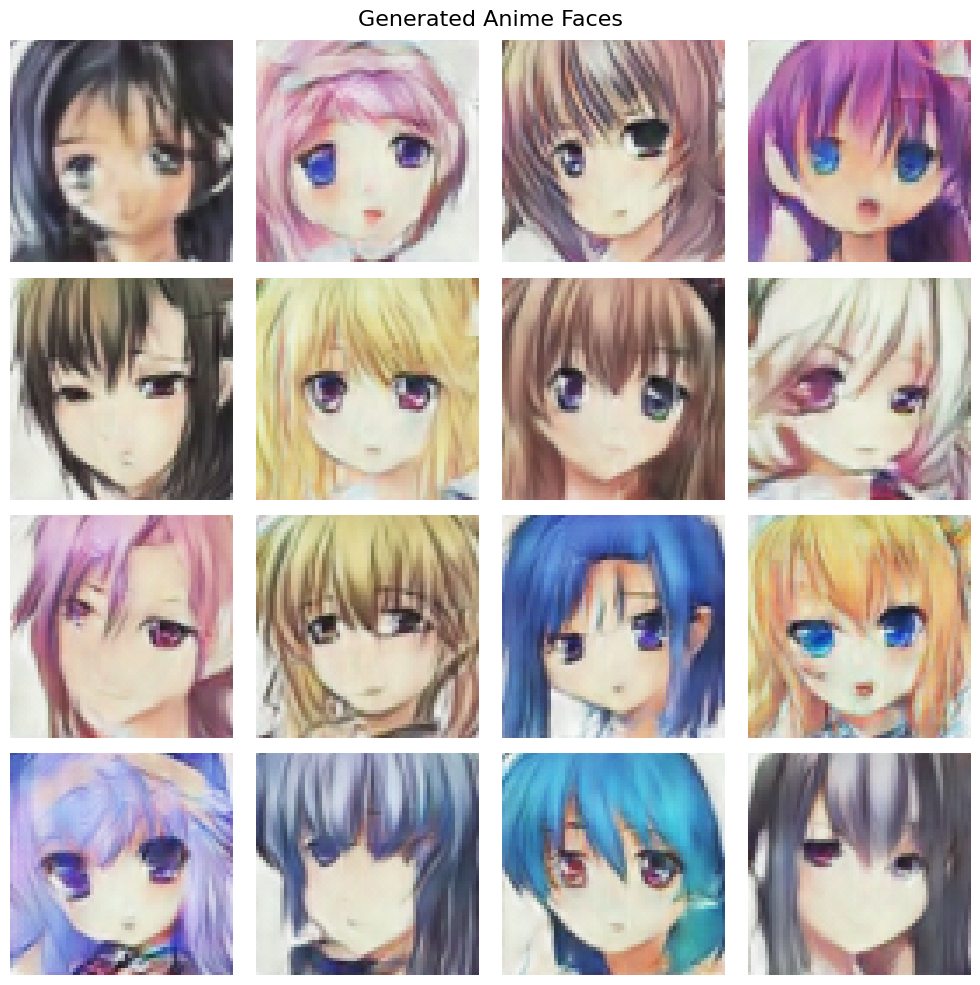

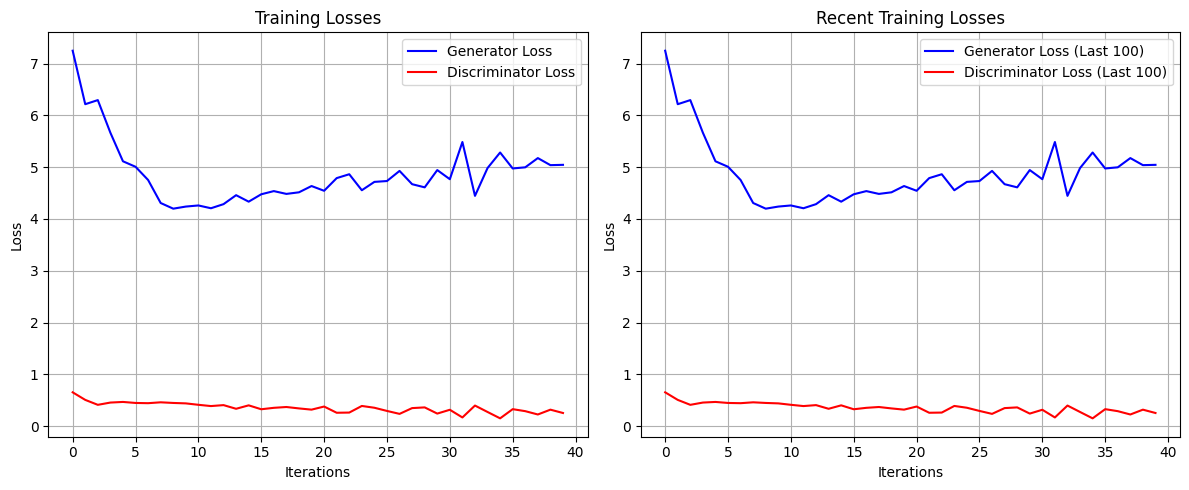

--------------------------------------------------


Epoch 41/50: 100%|██████████| 994/994 [01:00<00:00, 16.38it/s, D_loss=0.0672, G_loss=3.5178]


Epoch [41/50] - G_loss: 4.9274, D_loss: 0.2992


Epoch 42/50: 100%|██████████| 994/994 [01:00<00:00, 16.38it/s, D_loss=0.0777, G_loss=6.7675]


Epoch [42/50] - G_loss: 5.0468, D_loss: 0.2611


Epoch 43/50: 100%|██████████| 994/994 [01:00<00:00, 16.38it/s, D_loss=0.0206, G_loss=10.0552]


Epoch [43/50] - G_loss: 5.0297, D_loss: 0.2382


Epoch 44/50: 100%|██████████| 994/994 [01:00<00:00, 16.37it/s, D_loss=0.0658, G_loss=4.2148]


Epoch [44/50] - G_loss: 5.2995, D_loss: 0.2452


Epoch 45/50: 100%|██████████| 994/994 [01:00<00:00, 16.38it/s, D_loss=0.0908, G_loss=2.4464]


Epoch [45/50] - G_loss: 5.2915, D_loss: 0.1888

--- Generated Samples at Epoch 45 ---


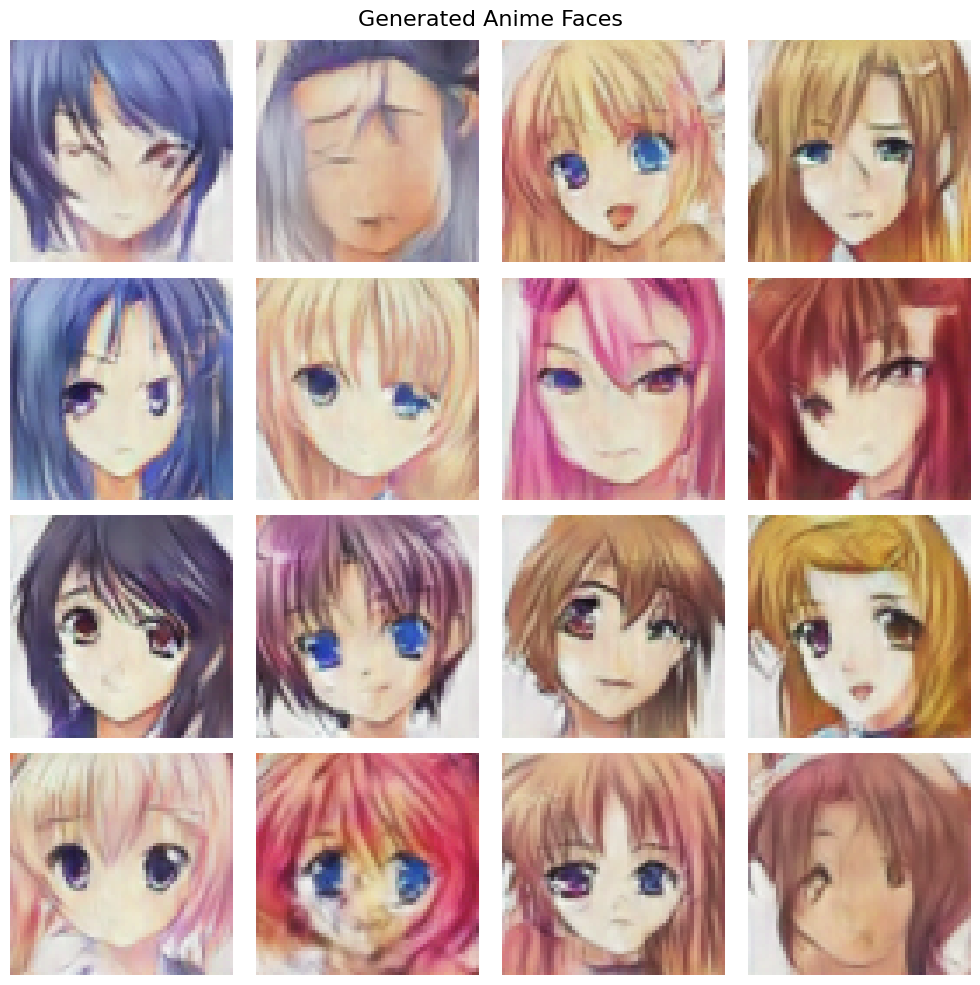

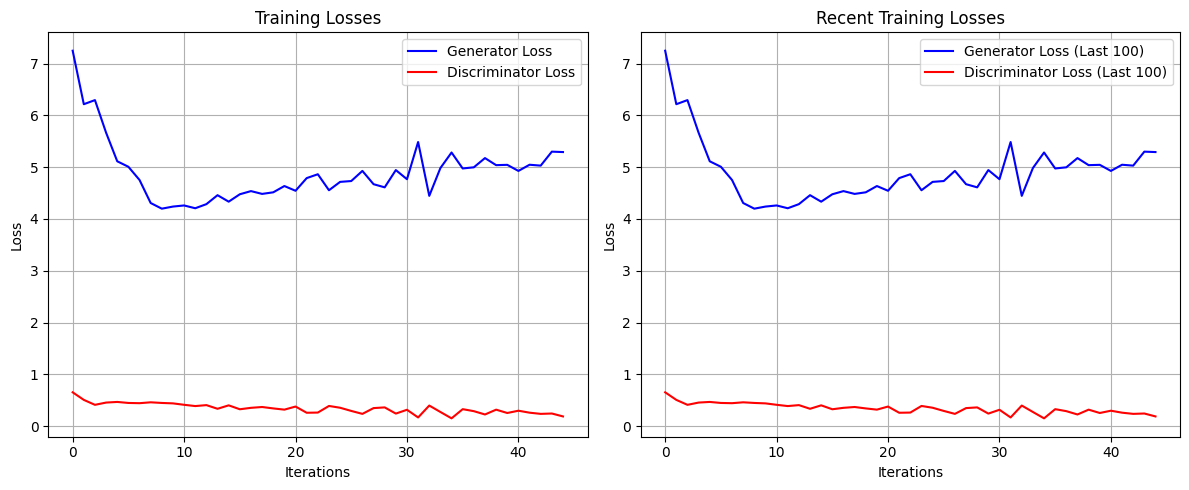

--------------------------------------------------


Epoch 46/50: 100%|██████████| 994/994 [01:00<00:00, 16.33it/s, D_loss=5.1177, G_loss=14.9915]


Epoch [46/50] - G_loss: 5.1492, D_loss: 0.2737


Epoch 47/50: 100%|██████████| 994/994 [01:00<00:00, 16.36it/s, D_loss=0.0250, G_loss=5.7212]


Epoch [47/50] - G_loss: 5.0650, D_loss: 0.2528


Epoch 48/50: 100%|██████████| 994/994 [01:00<00:00, 16.34it/s, D_loss=0.0105, G_loss=7.2017]


Epoch [48/50] - G_loss: 5.3168, D_loss: 0.2147


Epoch 49/50: 100%|██████████| 994/994 [01:00<00:00, 16.34it/s, D_loss=0.0946, G_loss=5.5579]


Epoch [49/50] - G_loss: 5.3482, D_loss: 0.2546


Epoch 50/50: 100%|██████████| 994/994 [01:00<00:00, 16.33it/s, D_loss=0.0163, G_loss=6.8198]


Epoch [50/50] - G_loss: 5.7082, D_loss: 0.1113

--- Generated Samples at Epoch 50 ---


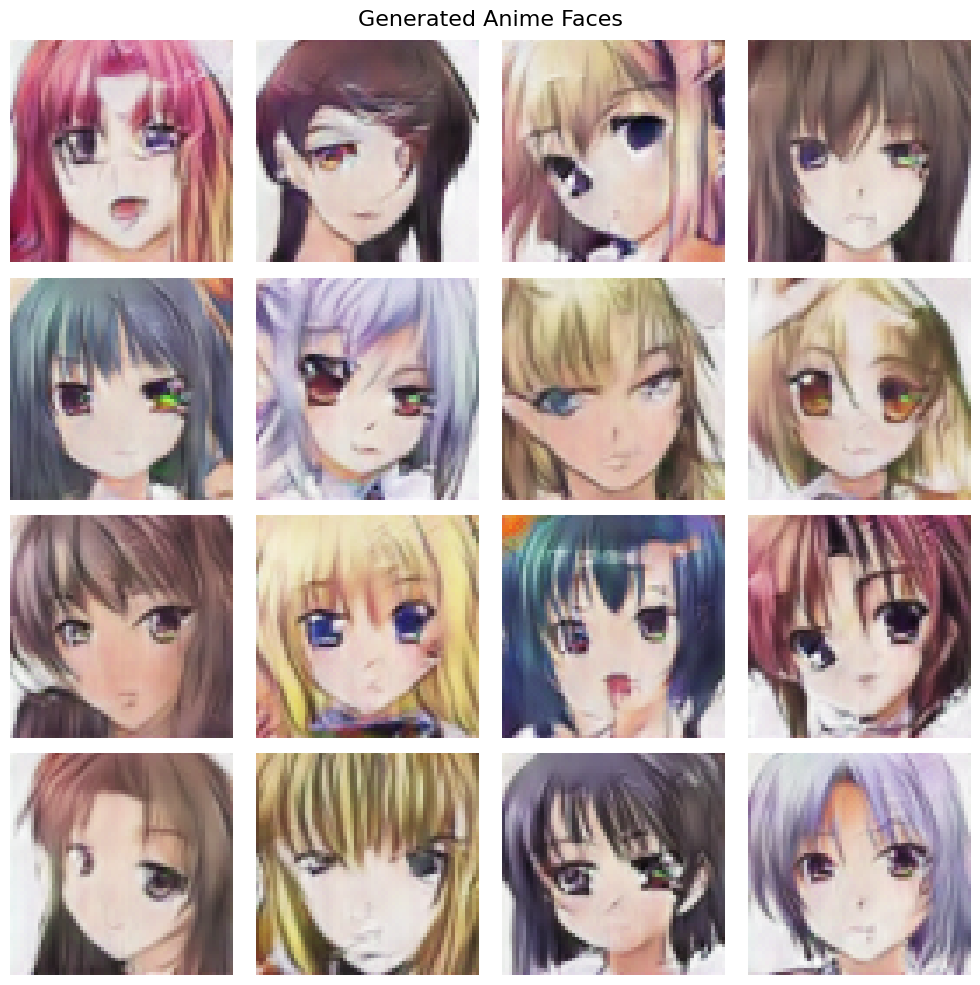

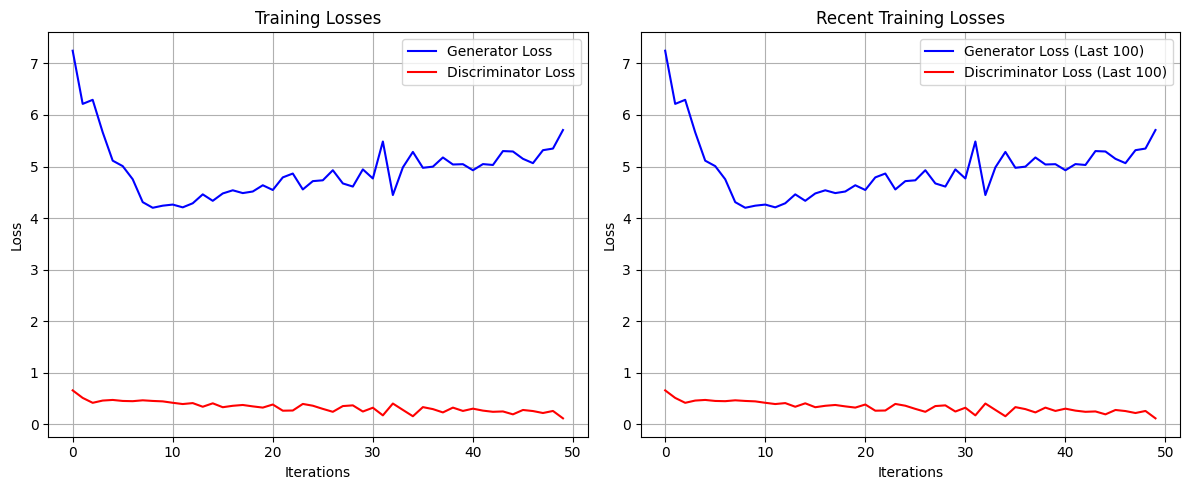

--------------------------------------------------
Training completed!
Training completed!


In [27]:
print("Starting Anime Face GAN Training (PyTorch)!")
print(f"Training with {len(anime_dataset)} images for {EPOCHS} epochs using PyTorch.")

gen_losses, disc_losses = train_gan(
    train_dataloader, generator, discriminator,
    optimizer_G, optimizer_D, criterion,
    NOISE_DIM, fixed_noise, device
)

print("Training completed!")

## Training Results Analysis

Let's analyze how our GAN performed during training by examining the loss curves and generating final samples.


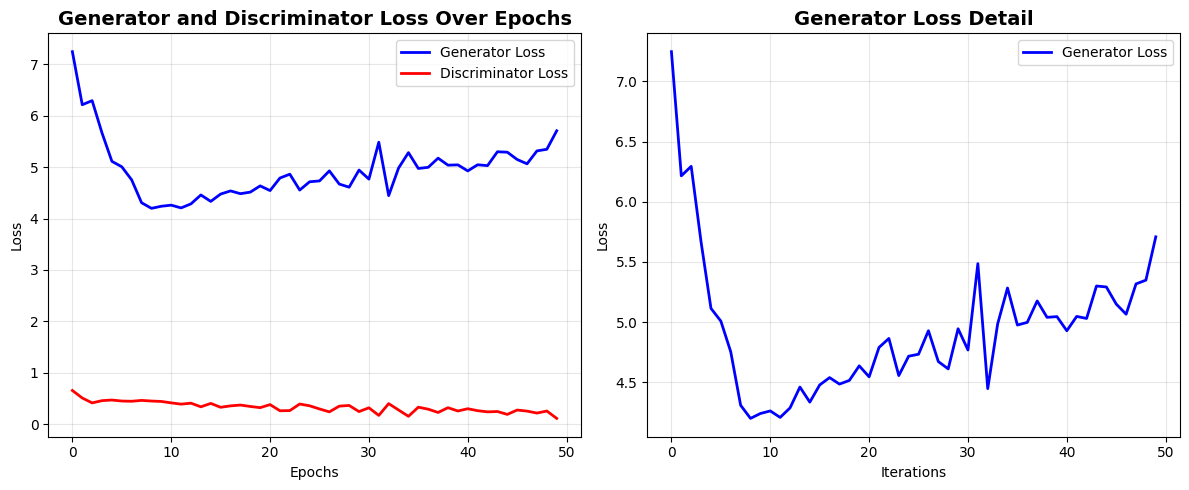

In [28]:
# Plot training losses
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title("Generator and Discriminator Loss Over Epochs", fontsize=14, fontweight='bold')
plt.plot(gen_losses, label='Generator Loss', color='blue', linewidth=2)
plt.plot(disc_losses, label='Discriminator Loss', color='red', linewidth=2)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(gen_losses, label='Generator Loss', color='blue', linewidth=2)
plt.title('Generator Loss Detail', fontsize=14, fontweight='bold')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [29]:
# Print final statistics
print("Training Statistics:")
print(f"Final Generator Loss: {gen_losses[-1]:.4f}")
print(f"Final Discriminator Loss: {disc_losses[-1]:.4f}")
print(f"Lowest Generator Loss: {min(gen_losses):.4f} (Epoch {np.argmin(gen_losses) + 1})")

Training Statistics:
Final Generator Loss: 5.7082
Final Discriminator Loss: 0.1113
Lowest Generator Loss: 4.1989 (Epoch 9)


## Final Results: Generated Anime Faces

Let's generate a final batch of anime faces using our trained generator and compare them with real images from our dataset.


Generating final anime faces (PyTorch)...


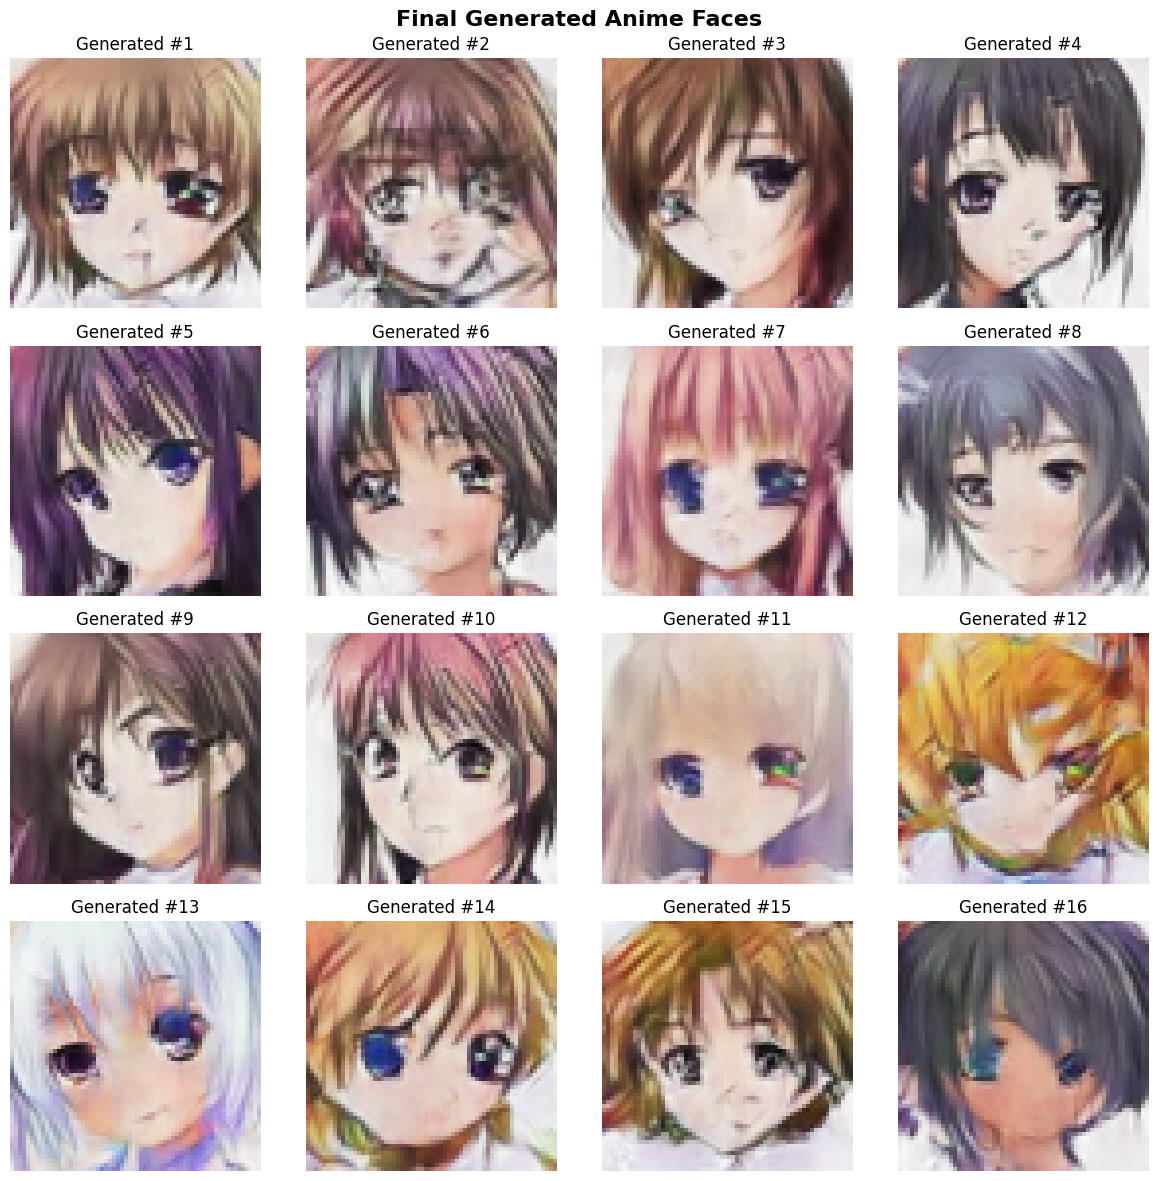

In [30]:
# Generate final images with the trained model
print("Generating final anime faces (PyTorch)...")
final_seed = torch.randn(16, NOISE_DIM, 1, 1, device=device)  # Add the missing dimensions
generator.eval() 
with torch.no_grad():
    final_generated_images = generator(final_seed).cpu() 
generator.train() 

fig, axes = plt.subplots(4, 4, figsize=(12, 12))
fig.suptitle('Final Generated Anime Faces', fontsize=16, fontweight='bold')
for i, ax in enumerate(axes.flat):
    img = final_generated_images[i] * 0.5 + 0.5 # Denormalize
    img = torch.clamp(img, 0.0, 1.0)
    ax.imshow(img.permute(1, 2, 0).numpy()) # C,H,W to H,W,C
    ax.set_title(f'Generated #{i+1}')
    ax.axis('off')
    
plt.tight_layout()
plt.show()

## Model Evaluation: Real vs Generated Comparison

Let's create a side-by-side comparison between real anime faces from our dataset and generated ones to evaluate the quality of our GAN.


In [31]:
def compare_real_vs_generated(dataloader, model_G, num_comparisons=8):
    """Compare real and generated images side by side"""
    # Get real images
    real_batch = next(iter(dataloader))
    real_images = real_batch[:num_comparisons].to(device if device.type != 'mps' else 'cpu')
    
    # Generate fake images - ADD THE MISSING DIMENSIONS
    noise = torch.randn(num_comparisons, NOISE_DIM, 1, 1, device=device)  # Changed this line
    model_G.eval()
    with torch.no_grad():
        generated_images = model_G(noise).cpu() # Generate and move to CPU
    model_G.train()
    
    fig, axes = plt.subplots(2, num_comparisons, figsize=(16, 4))
    fig.suptitle('Real vs Generated Anime Faces Comparison', fontsize=16, fontweight='bold')
    
    for i in range(num_comparisons):
        # Real images
        real_img_processed = real_images[i] * 0.5 + 0.5
        real_img_processed = torch.clamp(real_img_processed, 0.0, 1.0)
        axes[0, i].imshow(real_img_processed.cpu().permute(1, 2, 0).numpy()) # Move to CPU if not already
        axes[0, i].set_title('Real' if i == num_comparisons//2 else '')
        axes[0, i].axis('off')
        
        # Generated images
        gen_img_processed = generated_images[i] * 0.5 + 0.5
        gen_img_processed = torch.clamp(gen_img_processed, 0.0, 1.0)
        axes[1, i].imshow(gen_img_processed.permute(1, 2, 0).numpy()) # Already on CPU
        axes[1, i].set_title('Generated' if i == num_comparisons//2 else '')
        axes[1, i].axis('off')
        
    plt.tight_layout()
    plt.show()

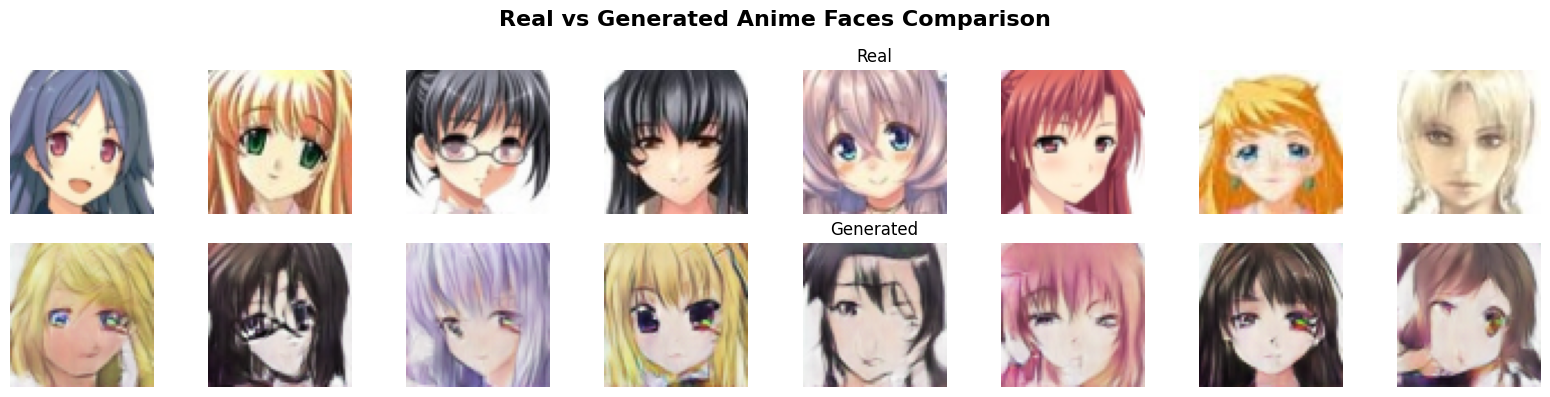

In [32]:
# Perform comparison
compare_real_vs_generated(train_dataloader, generator)

## Save Model and Generate Additional Samples

Finally, let's save our trained generator model and create a larger collection of generated anime faces to showcase our results.


In [33]:
# Save the generator model state_dict
torch.save(generator.state_dict(), 'anime_face_generator_pytorch.pth')
print("Generator model saved as 'anime_face_generator_pytorch.pth'")

Generator model saved as 'anime_face_generator_pytorch.pth'


# Conclusion and Next Steps

### What We Accomplished:
- Successfully implemented a GAN for anime face generation
- Processed 63,632 anime face images
- Trained both Generator and Discriminator networks
- Generated realistic anime faces from random noise
- Visualized training progress and final results

### Key Observations:
1. **Training Stability**: Monitor loss curves to ensure balanced training
2. **Image Quality**: Generated faces show clear anime characteristics
3. **Diversity**: Model produces varied faces with different styles and features
4. **Training Time**: ~{EPOCHS} epochs provided good results

In [34]:
print(f'Final Generator Loss: {gen_losses[-1]:.4f}')
print(f'Final Discriminator Loss: {disc_losses[-1]:.4f}')
print(f'Training Dataset Size: {dataset_size:,} images')

Final Generator Loss: 5.7082
Final Discriminator Loss: 0.1113
Training Dataset Size: 63,565 images


### Potential Improvements:
1. **Higher Resolution**: Train with 128x128 or 256x256 images
2. **Progressive Growing**: Implement progressive GAN architecture
3. **Style Transfer**: Add conditional generation for specific anime styles
4. **Advanced Architectures**: Try StyleGAN or WGAN-GP
5. **Data Augmentation**: Add more sophisticated augmentation techniques

## Additional Utility Functions

Here are some bonus utility functions we can use to further explore our trained GAN:

In [35]:
def interpolate_between_faces(model_G, face1_noise, face2_noise, steps=10): 
    """Create smooth interpolation between two generated faces using PyTorch."""
    interpolated_faces_tensors = [] 
    
    model_G.eval() 
    with torch.no_grad(): 
        for i in range(steps):
            alpha = i / (steps - 1)
            interpolated_noise = (1 - alpha) * face1_noise + alpha * face2_noise
            face_tensor = model_G(interpolated_noise).cpu()
            interpolated_faces_tensors.append(face_tensor[0]) 
    model_G.train() 
    
    # Display interpolation
    fig, axes = plt.subplots(1, steps, figsize=(20, 2))
    fig.suptitle('Face Interpolation (PyTorch)', fontsize=14, fontweight='bold')
    
    for i, ax in enumerate(axes):
        # Denormalize from [-1, 1] to [0, 1]
        img = interpolated_faces_tensors[i] * 0.5 + 0.5
        img = torch.clamp(img, 0.0, 1.0) # Clip values
        ax.imshow(img.permute(1, 2, 0).numpy())
        ax.axis('off')
        ax.set_title(f'Step {i+1}')
    
    plt.tight_layout()
    plt.show()

In [36]:
def generate_face_grid(model_G, rows=8, cols=8):
    """Generate a large grid of faces using PyTorch."""
    total_faces = rows * cols
    noise = torch.randn(total_faces, NOISE_DIM, 1, 1, device=device)
    
    model_G.eval() 
    with torch.no_grad(): 
        faces_tensors = model_G(noise).cpu()
    model_G.train()
    
    fig, axes = plt.subplots(rows, cols, figsize=(16, 16))
    fig.suptitle(f'{total_faces} Generated Anime Faces (PyTorch)', fontsize=16, fontweight='bold')
    
    for i, ax in enumerate(axes.flat):
        if i < total_faces:
            # Denormalize from [-1, 1] to [0, 1]
            img = faces_tensors[i] * 0.5 + 0.5
            img = torch.clamp(img, 0.0, 1.0) # Clip values
            ax.imshow(img.permute(1, 2, 0).numpy())
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

In [37]:
def analyze_generated_diversity(model_G, num_samples=100): #
    """Analyze the diversity of generated samples using PyTorch."""
    noise = torch.randn(num_samples, NOISE_DIM, 1, 1, device=device)
    
    model_G.eval() 
    with torch.no_grad():
        generated_faces_tensors = model_G(noise).cpu()
    model_G.train() 
    
    faces_np = generated_faces_tensors.numpy() * 0.5 + 0.5
    faces_np = np.clip(faces_np, 0.0, 1.0) # Clip after denormalization

    mean_pixel_values = np.mean(faces_np, axis=(1, 2, 3)) # N, C, H, W - mean over C, H, W
    std_pixel_values = np.std(faces_np, axis=(1, 2, 3))

    fig, axes = plt.subplots(1, 2, figsize=(12, 4)) 
    
    axes[0].hist(mean_pixel_values, bins=20, alpha=0.7, color='blue', edgecolor='black')
    axes[0].set_title('Distribution of Mean Pixel Values')
    axes[0].set_xlabel('Mean Pixel Value')
    axes[0].set_ylabel('Frequency')
    
    axes[1].hist(std_pixel_values, bins=20, alpha=0.7, color='green', edgecolor='black')
    axes[1].set_title('Distribution of Pixel Standard Deviations')
    axes[1].set_xlabel('Pixel Standard Deviation')
    axes[1].set_ylabel('Frequency')
    
    plt.suptitle('Generated Samples Diversity Analysis', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print(f"Diversity Analysis Results (PyTorch):")
    print(f"Mean pixel value range: {np.min(mean_pixel_values):.3f} - {np.max(mean_pixel_values):.3f}")
    print(f"Std pixel value range: {np.min(std_pixel_values):.3f} - {np.max(std_pixel_values):.3f}")
    print(f"Overall diversity score: {np.std(mean_pixel_values):.3f}")


Running utility functions (PyTorch)...


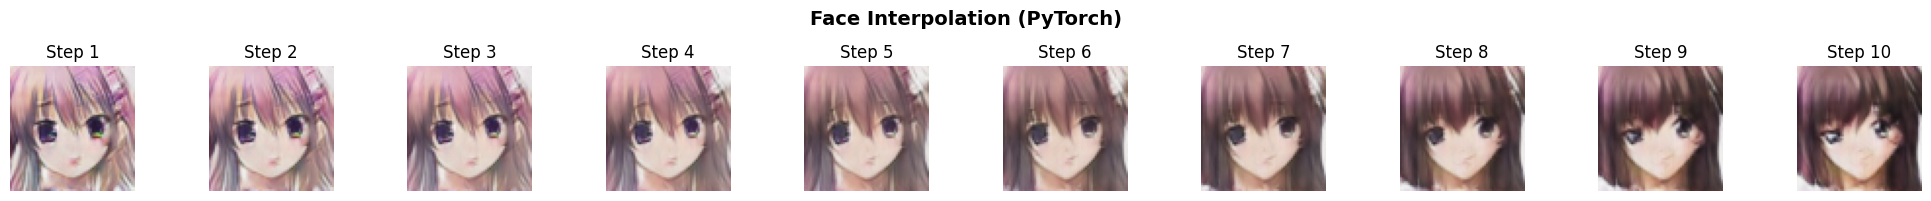

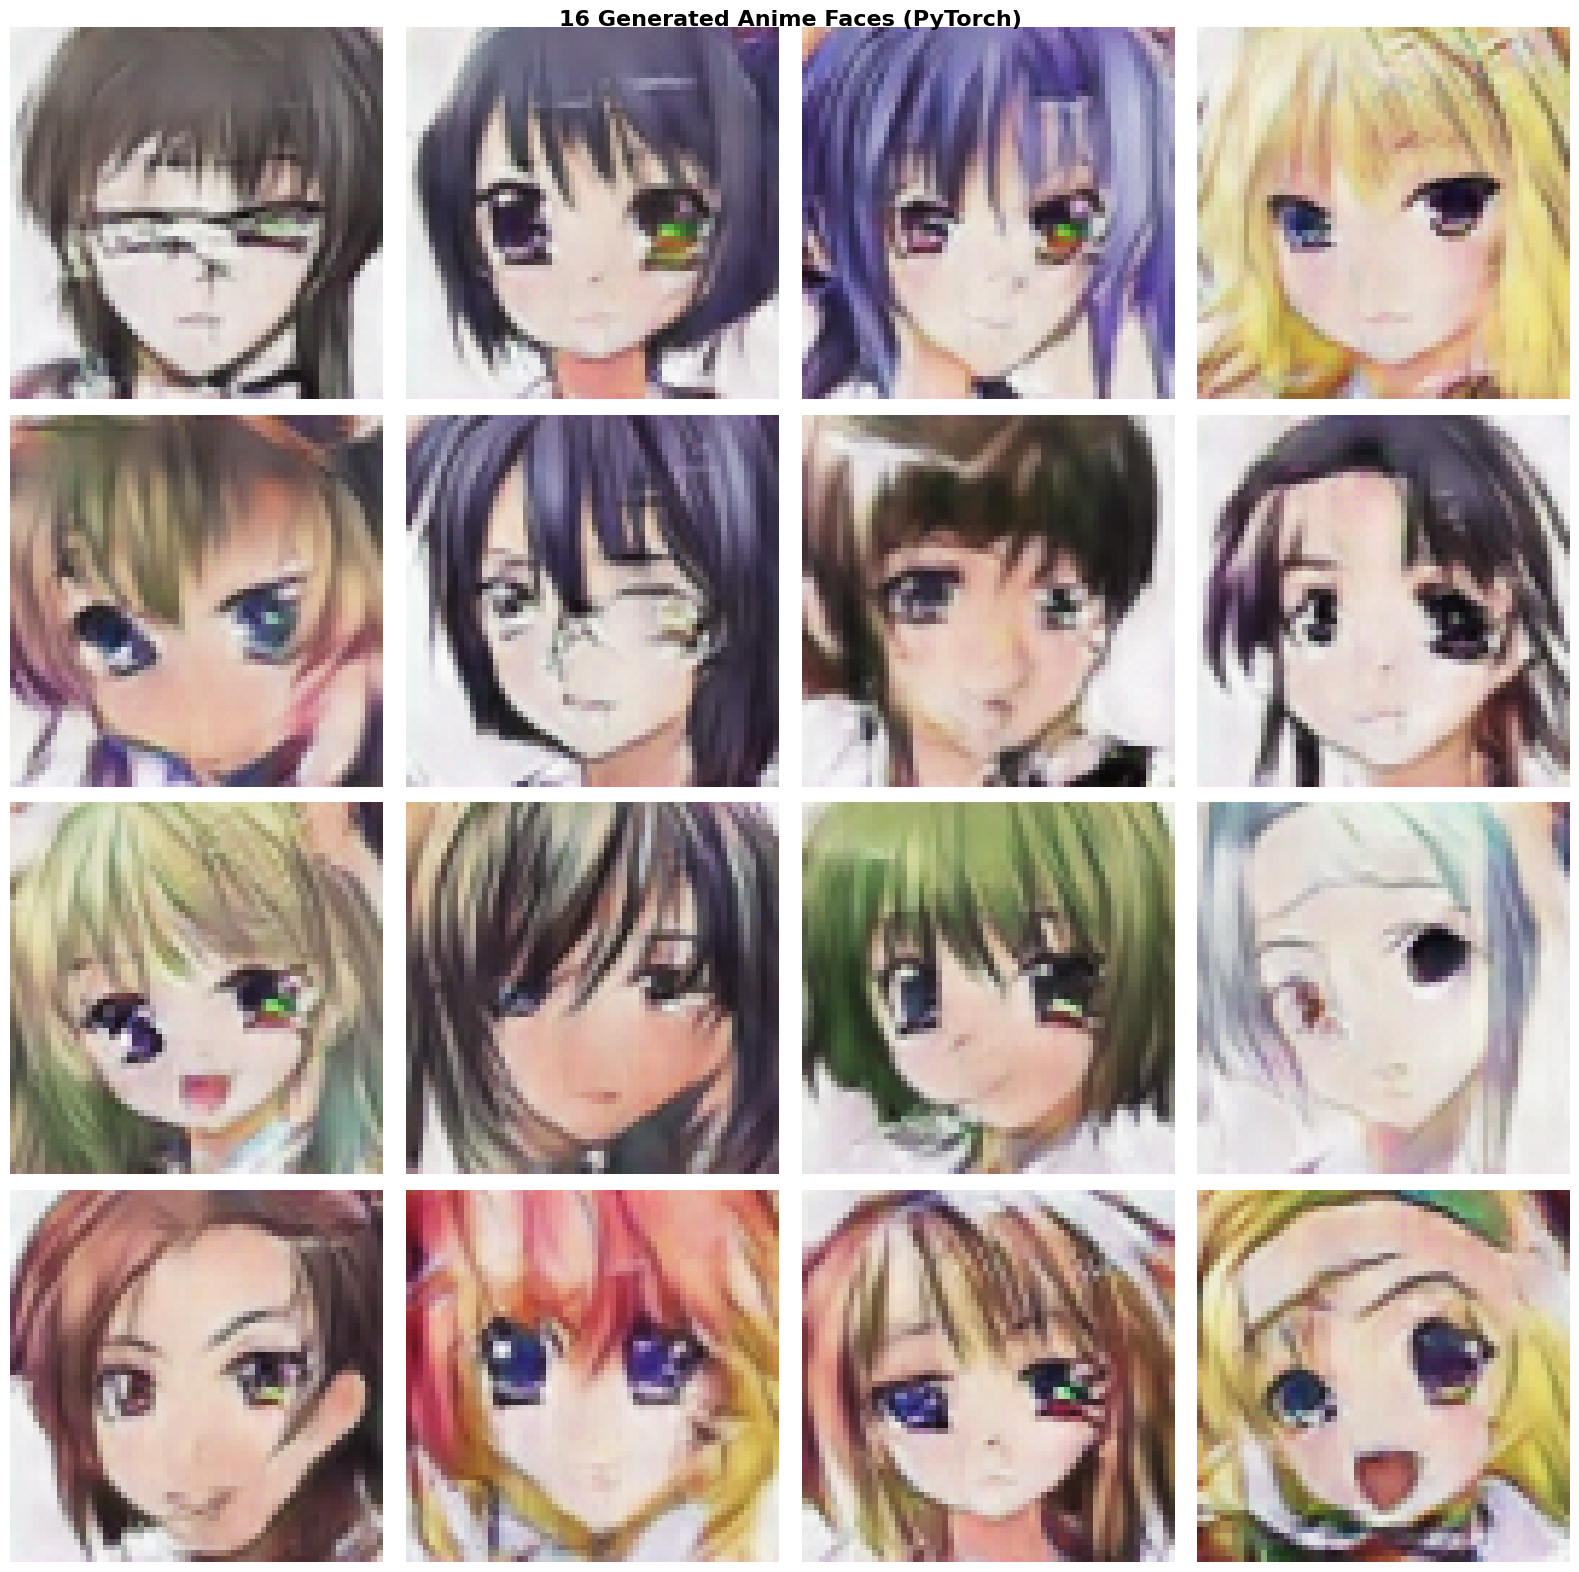

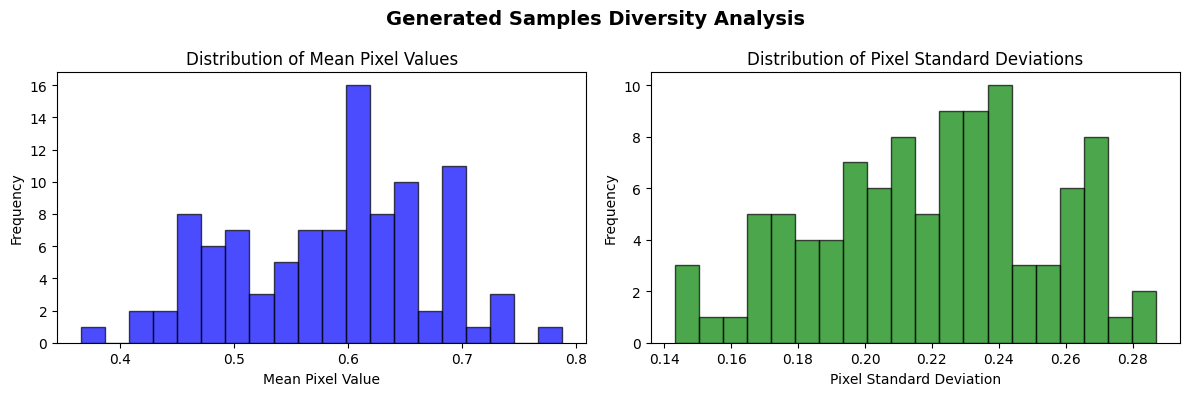

Diversity Analysis Results (PyTorch):
Mean pixel value range: 0.365 - 0.788
Std pixel value range: 0.143 - 0.287
Overall diversity score: 0.085


In [38]:
print("Running utility functions (PyTorch)...")

# Ensure noise tensors are created on the correct device for the model
noise1 = torch.randn(1, NOISE_DIM, 1, 1, device=device)
noise2 = torch.randn(1, NOISE_DIM, 1, 1, device=device)

interpolate_between_faces(generator, noise1, noise2)
generate_face_grid(generator, rows=4, cols=4) 
analyze_generated_diversity(generator)